In [1]:
import numpy as np
from sumolib import checkBinary
import math
import random
import time
import traci
import os
import sys
import psutil
import optparse
import keras
import json
import tensorflow as tf 
from keras.models import load_model

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from keras.models import Model
from keras.layers import Input,Dense,Flatten,concatenate

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

from datetime import datetime

Using TensorFlow backend.


# Vehicle class

In [2]:
class Vehicle:
    def __init__(self,vid,waiting_time,vtype):
        self.vid=vid
        self.waiting_time=waiting_time
        self.vtype=vtype

# Environment

In [3]:
class Sumo:
    # eight valid phases of the traffic light
    RedYellowGreenStates=["rrrrrGGrrrrrrGGr","rGGrrrrrrGGrrrrr","rrrrrrrrrrgrGGGG","GGGGrrrrrrrrrrgr","rrgrGGGGrrrrrrrr","rrrrrrgrGGGGrrrr","GrrrrrGrGrrrrrGr","rrGrGrrrrrGrGrrr"]
    
    def __init__(self,K,Z):
        self.K=K # K,Z are tunable constants
        self.Z=Z
        self.nearby_vehicles=[[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
        self.count=0
        if 'SUMO_HOME' in os.environ:
            tools=os.path.join(os.environ['SUMO_HOME'],'tools')
            sys.path.append(tools)
        else: 
            sys.exit("please declare environment variable 'SUMO_HOME'")
            
    def getSumoBinary(self,gui):
        if(gui):
            sumoBinary = checkBinary('sumo-gui')
        else:
            sumoBinary = checkBinary('sumo')
        return sumoBinary

    def updateWaitingTime(self):
        for i in range(1,5):
            for j in range(0,3):
                all_vehicles_on_lane = traci.lane.getLastStepVehicleIDs(str(i)+"si_"+str(j))
                
                for vehicle in self.nearby_vehicles[i-1][j]:# removing the vehicle from the memory which has went through the junction
                    if vehicle.vid not in all_vehicles_on_lane:
                        nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                        nearby_vehicle_on_lane.remove(vehicle)
                        self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane
                        
                for vehicle_id in all_vehicles_on_lane:
                    #getLanePosition outputs the position of the vehicle with respect to start end of the lane that is not the junction side
                    if(traci.vehicle.getLanePosition(vehicle_id)>=132):# consider vehicles which is 100M near or less to the junction lan length is 232
                        flag=1
                        for e,vehicle in enumerate(self.nearby_vehicles[i-1][j]):
                            if vehicle.vid==vehicle_id:#checking for exsisting vehicles
                                vehicle.waiting_time+=1
                                vehicle_list=self.nearby_vehicles[i-1][j]
                                vehicle_list[e]=vehicle# replace the old vehicle object with updated one
                                self.nearby_vehicles[i-1][j]=vehicle_list
                                flag=0
                                break
                        if(flag):
                            #register the new vehicle
                            new_vehicle_obj=Vehicle(vehicle_id,0,traci.vehicle.getTypeID(vehicle_id))
                            nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                            nearby_vehicle_on_lane.append(new_vehicle_obj)
                            self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane     
        return
    
    def getState(self):
        #onehot encode the phase index
        current_phase = self.RedYellowGreenStates.index(traci.trafficlight.getRedYellowGreenState('0'))
        num_classes = 8 # since we have 8 phases
        target = np.array(current_phase)
        phase_index = np.eye(num_classes)[target]#onehot encoding
        
        incomming_state=np.zeros([12,4]) # definition of a one row is (number of vehicles in that lane,average waiting time,std of waitig times,emergency or not)
        outgoing_state=np.ones(4) #will get the negetive impact of this [Left,Right,Bottom,Top]
        total_waiting_time_distribution=[]# this will contain all the vehicle waiting times around the junction
        emg_waiting_time_distribution = []# this will contain maximum waiting time of emg for each lane
        for i in range(1,5):
            for j in range(0,3):

                #prepairing incomming state          
                emergency_waiting_time=0
                waiting_time_distribution=[]
                for vehicle in self.nearby_vehicles[i-1][j]:
                    if vehicle.vtype == "emergency":
                        if vehicle.waiting_time > emergency_waiting_time:
                            emergency_waiting_time = vehicle.waiting_time
                    else:        
                        waiting_time_distribution.append(vehicle.waiting_time)
                        total_waiting_time_distribution.append(vehicle.waiting_time)

                if not waiting_time_distribution:# append 0 to empty list to get rid of nan issue
                    waiting_time_distribution.append(0)
                    
                if(emergency_waiting_time):
                    emg_waiting_time_distribution.append(emergency_waiting_time) #append the maximum emg waiting time of each lane
                
                waiting_time_mean =  np.mean(waiting_time_distribution)
                waiting_time_std = np.std(waiting_time_distribution)    
                
                #Scalling state representation
                #maximum waiting time of a vehicle is 100s
                #maximum number of vehicles that can be fit in to 100M range is 17 
                
                incomming_state[j+(i-1)*3][0] = len(self.nearby_vehicles[i-1][j])/17 # adding queue length
                
                if(waiting_time_mean>100): #adding average waiting time
                    incomming_state[j+(i-1)*3][1] = 1
                else:
                    incomming_state[j+(i-1)*3][1] = waiting_time_mean/100
                    
                if(waiting_time_std>100): #adding standard deviation 
                    incomming_state[j+(i-1)*3][2] = 1
                else:
                    incomming_state[j+(i-1)*3][2] = waiting_time_std/100
                 
                if(emergency_waiting_time>100): # adding emergency waiting time
                    incomming_state[j+(i-1)*3][3] = 1
                else:
                    incomming_state[j+(i-1)*3][3] = emergency_waiting_time/100
                
        
            #prepairing outgoing state      
            for vehicle_id in traci.lane.getLastStepVehicleIDs(str(i)+"o_0"):
                if(traci.vehicle.getLanePosition(vehicle_id) >= 386):#length of an outgoing road is 486M
                    outgoing_state[i-1] = outgoing_state[i-1] - 1/17 # - because of to get the negetive impact when the road is blocked
       
        #transforming outgoing state into attention state
        outgoing_state_final=np.ones(12)
        outgoing_state_final[4] = outgoing_state_final[6] = outgoing_state_final[11] = outgoing_state[0]
        outgoing_state_final[1] = outgoing_state_final[8] = outgoing_state_final[9] = outgoing_state[1]
        outgoing_state_final[2] = outgoing_state_final[3] = outgoing_state_final[10] = outgoing_state[2]
        outgoing_state_final[0] = outgoing_state_final[5] = outgoing_state_final[7] = outgoing_state[3]
            
        combined_traffic_state = np.append(incomming_state,outgoing_state_final.reshape(12,1),axis=1)
            
        if not total_waiting_time_distribution:# append 0 to empty list to get rid of nan issue
            total_waiting_time_distribution.append(0)
            
        if not emg_waiting_time_distribution:# append 0 to empty list to get rid of nan issue
            emg_waiting_time_distribution.append(0)
            
        ret_param1 = [combined_traffic_state.reshape(1,12,5),phase_index.reshape(1,8)]
        ret_param2 = [total_waiting_time_distribution,emg_waiting_time_distribution]
        return ret_param1,ret_param2
        
    def changePhase(self,next_phase_index):
       
        current_phase=traci.trafficlight.getRedYellowGreenState('0') # 0-7
        next_phase=self.RedYellowGreenStates[next_phase_index]
        
        
        if(next_phase != current_phase):#generate yellow phase
            yellow_phase = ""
            for i in range(0, len(current_phase)):
                if(current_phase[i].lower()=="g" and next_phase[i].lower()=="r"):

                    yellow_phase = yellow_phase+"y"
                else:
                    yellow_phase = yellow_phase+current_phase[i]

            traci.trafficlight.setRedYellowGreenState('0',yellow_phase) #set yellow phase

            for i in range(3): # allow yellow phase for 3 seconds
                traci.simulationStep()
                self.updateWaitingTime()
        traci.trafficlight.setRedYellowGreenState('0',next_phase)
        return
    
    def reward(self,current_state_distribution):
        
        #calculating the mean and the std of the mean of all the lanes for the current state   
        reg_waiting_time_mean =  np.mean(current_state_distribution[0])
        reg_waiting_time_std = np.std(current_state_distribution[0])
        
        emg_waiting_time_mean = np.mean(current_state_distribution[1])
        emg_waiting_time_std = np.std(current_state_distribution[1])


        reward = 50 - ((reg_waiting_time_mean + self.K*reg_waiting_time_std) + self.Z*(emg_waiting_time_mean + self.K*emg_waiting_time_std)) 
        
        return reward,round(reg_waiting_time_mean,2),round(reg_waiting_time_std,2),round(emg_waiting_time_mean,2),round(emg_waiting_time_std,2)


# Deep Q-network

In [4]:
class DQN:
    
    def load_model(self):
        try:
            return load_model('models/proposed/DQN.h5')
        except:
            print("No model found")
            return self.createDQN()
        
    def save_model(self):
        PolicyNetwork.save('models/DQN.h5')

    def createDQN(self):
        traffic_State = Input(shape = (12,5))
        phase_index = Input(shape = (8,))

        Dense1_out = Dense(50,name="Dense1",activation='relu')(traffic_State)
        Dense2_out = Dense(30,name="Dense2",activation='relu')(Dense1_out)
        Flatten_out = Flatten()(Dense2_out)
        Dense3_out = Dense(20,name="Dense3",activation='relu')(Flatten_out)
        
        Dense4_out = Dense(20,name="Dense4",activation='relu')(phase_index)
        
        Concatination_layer = concatenate([Dense3_out,Dense4_out])
        Dense5_out = Dense(16,name="Dense5",activation='relu')(Concatination_layer)
        Dense6_out = Dense(8,name="Dense6")(Dense5_out)#no activation function for last layer

        model = Model(inputs=[traffic_State,phase_index], outputs=[Dense6_out])
        model.compile(optimizer="Adam",loss="mse")
        plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
        return model

# Replay Memory

In [5]:
class ReplayMemory:
    def __init__(self,capacity,initial_state,initial_action):
        self.capacity=capacity
        self.replay_memory=[]
        self.push_count=0
        self.buffer_state=initial_state
        self.buffer_action=initial_action
        
    
    #also the next state cannot be directly observerd here because it takes time for vehicles to move and actualy become another
    #state after making a decision.
    def addToReplayBuffuer(self,current_state,action,reward):#here the reward is reward for the previous action
        
        experience=[self.buffer_state,self.buffer_action,reward,current_state]
        #buffer_state and buffer_action contains the previous state and the action now this reward and current state is corresponding to that experience
        self.buffer_state=current_state
        self.buffer_action=action
        
        if(len(self.replay_memory)<self.capacity):
            self.replay_memory.append(experience)
        else:
                # replace the oldest  experience with the new one in replay memory
            self.replay_memory[self.push_count%self.capacity]=experience
            self.push_count +=1
            
    def replay(self,replay_batch_size):

        if len(self.replay_memory) < replay_batch_size: 
            return

        replay_samples = random.sample(self.replay_memory, replay_batch_size)
#         print('experience replay....')
        for sample in replay_samples:

            state, action, reward, new_state = sample
            
            target = PolicyNetwork.predict(state)
            
            #only with fixed q targets
            #Q_future = max(TargetNetwork.predict(new_state)[0])
            
            #with double network concept
            best_action_new_state = np.argmax(PolicyNetwork.predict(new_state)[0])
            Q_future = TargetNetwork.predict(new_state)[0][best_action_new_state] 
            #q value for the best action from the target network
            
            
#             print(TargetNetwork.predict(new_state)[0])
            target[0][action] = reward + Q_future * gamma
            PolicyNetwork.fit(state, target, epochs=1, verbose=0)


# Agent

In [6]:
class Agent:
    
    def __init__(self,tau):
        self.step_number= -250 # -250 to prevent epsilon decaying bellow 1 before experience replay
        self.tau = tau
         
    def getAction(self,state):
        epsilon = math.exp(-1.*self.step_number*epsilon_decay)
        epsilon = max(epsilon_min, epsilon)
        self.step_number+=1
        print(epsilon)
        if np.random.random() < epsilon:
            return np.random.randint(0,action_space)
        else:
            return np.argmax(PolicyNetwork.predict(state)[0])
             
    def update_target_graph(self):
        weights = PolicyNetwork.get_weights()
        target_weights =TargetNetwork.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * (weights[i] - target_weights[i]) + target_weights[i] 
        TargetNetwork.set_weights(target_weights)    
        

In [7]:
action_space=8 #action is to choose next phase,agent will take an action within last 4seconds of the current phase
minimum_phase_duration=12
DQNet=DQN()
PolicyNetwork = DQNet.load_model()

PolicyNetwork.summary()
TargetNetwork = DQNet.load_model()
#parameaters to be tuned

gamma = 0.999
epsilon_min = 0.01
epsilon_decay = 0.0002 #0.0003
learning_rate = 0.001
tau = 0.125
replay_memory_capacity = 10000
replay_batch_size=256

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 5)        0                                            
__________________________________________________________________________________________________
Dense1 (Dense)                  (None, 12, 50)       300         input_1[0][0]                    
__________________________________________________________________________________________________
Dense2 (Dense)                  (None, 12, 30)       1530        Dense1[0][0]                     
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 360)          0           Dense2[0][0]                     
__________________________________________________________________________________________________
input_2 (I

# Training

In [8]:
sumo_env=Sumo(K=.5,Z=1)

initial_state=[np.zeros([12,5]).reshape(1,12,5),np.zeros(8).reshape(1,8)]
replayMemory=ReplayMemory(replay_memory_capacity,initial_state,0)
agent=Agent(tau)

step_count = 1  
action_count=[]
steps_per_episode=5000
regular_waiting_history=[]
emergency_waiting_history=[]
regular_std_history=[]
emergency_std_history=[]
reward_history=[]
episode_no = 0


In [9]:
while True:
    if(episode_no>30):
        break
    print("============== episode {} =================".format(episode_no))
    traci.start([sumo_env.getSumoBinary(gui=False), "-c", "cross3ltl.sumocfg", '--start'])
    initial_steps = 0
    while initial_steps < 100: # take initial environment to intermediat trafic state
        traci.simulationStep()
        initial_steps +=1

    while step_count % steps_per_episode != 0:
            
            step_count += 1
            traci.simulationStep()
            sumo_env.updateWaitingTime()
            if(step_count % 12 == 0):#agent will make a decision at the 12th second of the current phase

                current_state,current_waiting_distribution=sumo_env.getState()
                action=agent.getAction(current_state)
                sumo_env.changePhase(action)
#                 print(current_state)
#                 print(current_state_distribution)
                reward,regular_waiting,regular_std,emergency_waiting,emergency_std=sumo_env.reward(current_waiting_distribution)

                replayMemory.addToReplayBuffuer(current_state,action,reward)
                replayMemory.replay(replay_batch_size)#experience replay is performed after each action
                 
                print("episode ",episode_no," waiting ",regular_waiting," regular_std ",regular_std," reward ",reward)
                 
                action_count.append(step_count)

                regular_waiting_history.append(regular_waiting)
                emergency_waiting_history.append(emergency_waiting)

                regular_std_history.append(regular_std)
                emergency_std_history.append(emergency_std)

                reward_history.append(reward)
    #                 print('reg_waiting : ',regular_waiting,'emg_waiting : ',emergency_waiting,'reg_std : ',regular_std,'emg_std : ',emg_std,'reward : ',reward_history)

            if(step_count % steps_per_episode/4 == 0):
                agent.update_target_graph()#updating target graph is performed 4 times per episode

    step_count+=1
    traci.close(wait=False)
    episode_no += 1

============== episode 0 =================
1.0512710963760241
episode  0  waiting  8.44  regular_std  3.01  reward  40.05762510902069
1.0510608631807692
episode  0  waiting  18.86  regular_std  8.06  reward  27.11236114866689
1.050850672027949
episode  0  waiting  27.4  regular_std  12.44  reward  16.382283377316078
1.0506405229091558
episode  0  waiting  33.0  regular_std  19.69  reward  7.153318180364366
1.0504304158159836
episode  0  waiting  44.69  regular_std  24.58  reward  -6.977231915272931
1.050220350740028
episode  0  waiting  53.87  regular_std  30.44  reward  -19.089134906960425
1.050010327672887
episode  0  waiting  59.3  regular_std  35.73  reward  -27.16530622930003
1.049800346606159
episode  0  waiting  58.58  regular_std  45.88  reward  -31.515081461804087
1.049590407531445
episode  0  waiting  57.73  regular_std  49.29  reward  -32.380149670449896
1.0493805104403475
episode  0  waiting  60.23  regular_std  50.17  reward  -35.31612647217591
1.0491706553244706
episode  

episode  0  waiting  68.44  regular_std  60.66  reward  -48.76898567804584
1.0329305949196554
episode  0  waiting  71.59  regular_std  70.86  reward  -57.022821174887824
1.0327240294579063
episode  0  waiting  50.63  regular_std  40.42  reward  -20.84374993308093
1.0325175053051183
episode  0  waiting  44.61  regular_std  46.16  reward  -17.688302277200563
1.032311022453031
episode  0  waiting  53.28  regular_std  47.41  reward  -26.983805601632838
1.0321045808933844
episode  0  waiting  56.33  regular_std  52.82  reward  -32.7430327299986
1.0318981806179213
episode  0  waiting  54.22  regular_std  54.44  reward  -31.439988943320984
1.0316918216183855
episode  0  waiting  49.14  regular_std  49.49  reward  -23.885178926727065
1.0314855038865227
episode  0  waiting  44.29  regular_std  50.41  reward  -19.496310587973866
1.0312792274140803
episode  0  waiting  49.25  regular_std  50.96  reward  -24.72793162719455
1.031072992192807
episode  0  waiting  32.28  regular_std  23.68  reward  5

episode  0  waiting  31.15  regular_std  25.23  reward  6.238878149185908
1.014707100588091
episode  0  waiting  29.15  regular_std  22.19  reward  9.751549901605372
1.0145041794607625
episode  0  waiting  34.89  regular_std  24.76  reward  2.731817367918538
1.0143012989136013
episode  0  waiting  39.78  regular_std  27.99  reward  -3.7777531207575237
1.0140984589384923
episode  0  waiting  46.25  regular_std  30.59  reward  -11.543596608457484
1.0138956595273219
episode  0  waiting  39.77  regular_std  34.13  reward  -6.837721881545413
1.0136929006719777
episode  0  waiting  50.39  regular_std  37.28  reward  -19.028481523392642
1.0134901823643498
episode  0  waiting  61.69  regular_std  41.32  reward  -32.35668168631895
1.0132875045963292
episode  0  waiting  46.32  regular_std  33.27  reward  -12.958330672744324
1.0130848673598092
episode  0  waiting  39.97  regular_std  29.34  reward  -4.638278566364193
1.0128822706466838
episode  0  waiting  35.89  regular_std  24.37  reward  1.92

episode  0  waiting  31.69  regular_std  27.43  reward  4.595814506138879
0.997004495503373
episode  0  waiting  26.14  regular_std  26.5  reward  9.604752493886267
0.9968051145430329
episode  0  waiting  32.29  regular_std  29.91  reward  -13.245400290934406
0.9966057734548976
episode  0  waiting  28.26  regular_std  23.58  reward  9.948308308141797
0.9964064722309933
episode  0  waiting  27.96  regular_std  26.08  reward  9.001281346226342
0.9962072108633482
episode  0  waiting  38.91  regular_std  31.11  reward  -4.46464318509738
0.9960079893439915
episode  0  waiting  43.27  regular_std  36.21  reward  -11.372331700110244
0.9958088076649545
episode  0  waiting  30.9  regular_std  29.93  reward  4.136620111444252
0.99560966581827
episode  0  waiting  41.16  regular_std  35.39  reward  -11.856146473173183
0.9954105637959723
episode  0  waiting  46.03  regular_std  37.28  reward  -14.676520329760947
0.9952115015900972
episode  0  waiting  47.28  regular_std  39.96  reward  -17.2557556

episode  0  waiting  36.75  regular_std  22.37  reward  2.0638385344510013
0.9798066722428721
episode  0  waiting  39.26  regular_std  29.63  reward  -4.076561445717623
0.9796107305032505
episode  0  waiting  42.71  regular_std  31.94  reward  -8.684602568004152
0.9794148279480585
episode  0  waiting  43.11  regular_std  35.75  reward  -10.980876221713203
0.9792189645694596
episode  0  waiting  29.04  regular_std  24.69  reward  8.611413342552808
0.9790231403596195
episode  0  waiting  33.09  regular_std  28.09  reward  2.8658303526137203
0.978827355310705
episode  0  waiting  30.67  regular_std  22.7  reward  -1.0171438959876156
0.9786316094148849
episode  0  waiting  27.25  regular_std  18.72  reward  -10.6122135025146
0.9784359026643293
episode  0  waiting  31.19  regular_std  21.88  reward  7.865519806161615
0.97824023505121
episode  0  waiting  27.39  regular_std  23.1  reward  11.056602739561683
0.9780446065677002
episode  0  waiting  25.74  regular_std  17.32  reward  1.60314375

episode  1  waiting  73.91  regular_std  54.83  reward  -51.32255354853683
0.9629055027349203
episode  1  waiting  46.04  regular_std  38.49  reward  -15.285972732935264
0.9627129408911995
episode  1  waiting  55.11  regular_std  45.73  reward  -27.975377803004477
0.9625204175559966
episode  1  waiting  35.38  regular_std  33.3  reward  -2.0247700809951112
0.9623279327216104
episode  1  waiting  36.9  regular_std  36.09  reward  -4.947637270787212
0.9621354863803417
episode  1  waiting  35.6  regular_std  27.15  reward  0.8266805828493062
0.9619430785244926
episode  1  waiting  39.12  regular_std  31.29  reward  -4.761302566106139
0.9617507091463667
episode  1  waiting  41.2  regular_std  36.18  reward  -9.290236777518054
0.9615583782382694
episode  1  waiting  41.64  regular_std  38.87  reward  -11.073929093212215
0.9613660857925073
episode  1  waiting  38.73  regular_std  34.82  reward  -6.139508379630044
0.9611738318013887
episode  1  waiting  48.13  regular_std  36.04  reward  -16.

episode  1  waiting  41.59  regular_std  41.46  reward  -12.321471238341061
0.9461066296030195
episode  1  waiting  45.97  regular_std  45.0  reward  -18.46795675313851
0.94591742719797
episode  1  waiting  52.06  regular_std  47.56  reward  -25.84059521193916
0.9457282626296178
episode  1  waiting  37.06  regular_std  27.14  reward  -0.6267036233031718
0.9455391358903963
episode  1  waiting  37.86  regular_std  26.45  reward  -1.0885956639031846
0.9453500469727403
episode  1  waiting  42.67  regular_std  26.31  reward  -5.823836237327029
0.9451609958690862
episode  1  waiting  48.47  regular_std  34.08  reward  -15.510368195592577
0.9449719825718722
episode  1  waiting  55.11  regular_std  38.14  reward  -24.17937692734131
0.9447830070735376
episode  1  waiting  56.18  regular_std  41.81  reward  -27.084259730854455
0.9445940693665233
episode  1  waiting  62.69  regular_std  45.66  reward  -35.522285688264816
0.944405169443272
episode  1  waiting  65.6  regular_std  46.74  reward  -38

episode  1  waiting  75.03  regular_std  52.16  reward  -51.11150006320635
0.9296008300257927
episode  1  waiting  83.74  regular_std  60.6  reward  -64.04124020865649
0.9294149284505647
episode  1  waiting  83.37  regular_std  67.53  reward  -67.13829434972958
0.9292290640519341
episode  1  waiting  89.79  regular_std  70.72  reward  -75.15135434514421
0.929043236822466
episode  1  waiting  75.23  regular_std  77.89  reward  -64.17957599852079
0.9288574467547276
episode  1  waiting  90.46  regular_std  86.86  reward  -83.888586967886
0.9286716938412872
episode  1  waiting  89.29  regular_std  78.5  reward  -87.54323330059648
0.9284859780747147
episode  1  waiting  96.08  regular_std  82.09  reward  -111.13028730747806
0.9283002994475813
episode  1  waiting  103.97  regular_std  91.65  reward  -138.79481848365367
0.9281146579524602
episode  1  waiting  109.51  regular_std  93.43  reward  -160.2283791406611
0.9279290535819253
episode  1  waiting  100.06  regular_std  84.44  reward  -161

episode  1  waiting  57.5  regular_std  55.41  reward  -35.20311354342684
0.9135656859018669
episode  1  waiting  29.73  regular_std  30.47  reward  5.036701247798625
0.9133829910347823
episode  1  waiting  36.93  regular_std  34.14  reward  -4.000336219044165
0.9132003327030173
episode  1  waiting  32.42  regular_std  35.43  reward  -0.13724610881149601
0.9130177108992658
episode  1  waiting  35.86  regular_std  32.08  reward  -1.8993384929131167
0.9128351256162228
episode  1  waiting  42.0  regular_std  34.84  reward  -9.417772184719489
0.9126525768465851
episode  1  waiting  47.21  regular_std  36.78  reward  -15.601083780915872
0.9124700645830505
episode  1  waiting  45.24  regular_std  39.69  reward  -15.088388815290557
0.9122875888183186
episode  1  waiting  53.97  regular_std  42.78  reward  -31.363083590059503
0.9121051495450904
episode  1  waiting  59.9  regular_std  47.62  reward  -54.710821663255985
0.9119227467560683
episode  1  waiting  56.37  regular_std  38.79  reward  -

episode  1  waiting  32.06  regular_std  25.37  reward  5.253271665666844
0.8978071399034698
episode  1  waiting  42.27  regular_std  30.09  reward  -7.315229042849566
0.8976275964304349
episode  1  waiting  43.93  regular_std  33.22  reward  -10.539093358225244
0.8974480888625039
episode  1  waiting  40.25  regular_std  40.13  reward  -21.316685700433936
0.8972686171924966
episode  1  waiting  31.9  regular_std  31.3  reward  -23.55079870166375
0.8970891814132342
episode  1  waiting  20.48  regular_std  21.1  reward  -22.02496500174223
0.8969097815175392
episode  1  waiting  24.82  regular_std  23.54  reward  -42.58643298550443
0.8967304174982355
episode  1  waiting  34.43  regular_std  26.89  reward  -68.87937590291176
0.8965510893481485
episode  1  waiting  27.69  regular_std  24.16  reward  -75.77357834533571
0.8963717970601054
episode  1  waiting  33.17  regular_std  24.65  reward  -96.49014245702531
0.8961925406269342
episode  1  waiting  45.65  regular_std  30.64  reward  -126.9

episode  2  waiting  42.74  regular_std  32.52  reward  -9.002256656018318
0.8823204208528399
episode  2  waiting  43.5  regular_std  29.28  reward  -8.142261892663079
0.8821439744139014
episode  2  waiting  57.65  regular_std  32.73  reward  -24.01321937121635
0.881967563260722
episode  2  waiting  61.84  regular_std  38.2  reward  -30.944504642551607
0.8817911873862452
episode  2  waiting  56.91  regular_std  48.15  reward  -30.982326278625777
0.8816148467834161
episode  2  waiting  48.25  regular_std  46.4  reward  -21.450148167630317
0.8814385414451809
episode  2  waiting  49.69  regular_std  47.35  reward  -23.368719692589764
0.8812622713644874
episode  2  waiting  56.74  regular_std  52.04  reward  -32.763022002863934
0.8810860365342851
episode  2  waiting  38.15  regular_std  29.9  reward  -3.1035646408356854
0.8809098369475242
episode  2  waiting  31.96  regular_std  25.63  reward  5.219599925761287
0.880733672597157
episode  2  waiting  31.85  regular_std  23.19  reward  6.551

episode  2  waiting  69.42  regular_std  68.13  reward  -53.48422989791351
0.867100839872619
episode  2  waiting  92.19  regular_std  72.28  reward  -78.330402665397
0.8669274370455051
episode  2  waiting  83.3  regular_std  80.67  reward  -73.6330304997525
0.8667540688954889
episode  2  waiting  57.89  regular_std  59.82  reward  -37.79997110779519
0.8665807354156356
episode  2  waiting  69.11  regular_std  63.16  reward  -50.69325953020116
0.8664074365990119
episode  2  waiting  70.61  regular_std  67.06  reward  -54.14446693566501
0.8662341724386856
episode  2  waiting  65.09  regular_std  70.49  reward  -50.33895343584891
0.8660609429277264
episode  2  waiting  61.42  regular_std  71.33  reward  -47.08701598360764
0.865887748059205
episode  2  waiting  58.21  regular_std  72.89  reward  -44.653552847973714
0.8657145878261937
episode  2  waiting  37.31  regular_std  29.35  reward  -1.9787640608384436
0.865541462221766
episode  2  waiting  47.28  regular_std  31.62  reward  -13.08559

episode  2  waiting  112.23  regular_std  88.62  reward  -303.5428851957539
0.8519733772501578
episode  2  waiting  114.3  regular_std  90.72  reward  -295.65846117319234
0.8518029996130393
episode  2  waiting  106.69  regular_std  97.01  reward  -219.19753116278065
0.8516326560480411
episode  2  waiting  103.96  regular_std  100.16  reward  -104.03780324192635
0.8514623465483491
episode  2  waiting  74.23  regular_std  70.5  reward  -59.48038407816972
0.8512920711071511
episode  2  waiting  76.72  regular_std  71.19  reward  -62.3184526390928
0.8511218297176362
episode  2  waiting  85.55  regular_std  76.31  reward  -73.707526525214
0.8509516223729944
episode  2  waiting  74.0  regular_std  52.7  reward  -50.34781427506219
0.8507814490664177
episode  2  waiting  57.49  regular_std  39.79  reward  -27.381352597860072
0.8506113097910991
episode  2  waiting  50.21  regular_std  43.73  reward  -22.068685135108893
0.850441204540233
episode  2  waiting  59.83  regular_std  48.12  reward  -3

episode  2  waiting  30.87  regular_std  25.76  reward  6.249946239561673
0.8371098287134303
episode  2  waiting  40.17  regular_std  28.85  reward  -10.595432084230005
0.836942423488768
episode  2  waiting  45.84  regular_std  32.88  reward  -12.279072695728047
0.8367750517418029
episode  2  waiting  54.04  regular_std  35.06  reward  -21.567821946969346
0.83660771346584
episode  2  waiting  61.86  regular_std  37.6  reward  -30.657019828805716
0.8364404086541857
episode  2  waiting  72.24  regular_std  40.23  reward  -42.36164425940531
0.8362731373001477
episode  2  waiting  78.36  regular_std  48.54  reward  -52.62789279860715
0.8361058993970355
episode  2  waiting  84.24  regular_std  56.92  reward  -76.69646280911478
0.8359386949381593
episode  2  waiting  88.92  regular_std  56.13  reward  -95.98970657818938
0.8357715239168311
episode  2  waiting  92.84  regular_std  61.25  reward  -73.46805524610237
0.8356043863263639
episode  2  waiting  99.51  regular_std  71.1  reward  -85.06

episode  2  waiting  43.24  regular_std  36.03  reward  -11.254619255381897
0.8225055900107926
episode  2  waiting  46.91  regular_std  40.53  reward  -17.176008136047187
0.8223411053418056
episode  2  waiting  35.78  regular_std  32.44  reward  -1.9955283030129465
0.822176653566463
episode  2  waiting  38.77  regular_std  35.82  reward  -8.684082113481367
0.8220122346781865
episode  2  waiting  45.08  regular_std  36.99  reward  -27.575361580677466
0.8218478486703996
episode  2  waiting  44.12  regular_std  36.05  reward  -41.14171520911766
0.8216834955365268
episode  2  waiting  37.12  regular_std  37.31  reward  -49.77492964339453
0.8215191752699939
episode  2  waiting  46.27  regular_std  41.05  reward  -75.79667847875997
0.8213548878642281
episode  2  waiting  41.7  regular_std  29.45  reward  -80.42172693546433
0.821190633312658
episode  2  waiting  50.12  regular_std  33.07  reward  -86.39933972593312
0.8210264116087131
episode  2  waiting  47.34  regular_std  37.21  reward  -11

episode  3  waiting  82.14  regular_std  79.75  reward  -108.01670156984656
0.808317784608132
episode  3  waiting  83.19  regular_std  82.49  reward  -74.43227949919844
0.8081561372164884
episode  3  waiting  62.08  regular_std  53.9  reward  -39.02663517647102
0.8079945221510904
episode  3  waiting  55.26  regular_std  55.35  reward  -32.937410656608805
0.8078329394054733
episode  3  waiting  23.07  regular_std  16.85  reward  18.50823854323024
0.8076713889731739
episode  3  waiting  21.82  regular_std  18.09  reward  19.132077957312873
0.8075098708477302
episode  3  waiting  32.24  regular_std  21.59  reward  6.969105727708367
0.8073483850226815
episode  3  waiting  21.85  regular_std  17.61  reward  19.34640578123166
0.8071869314915683
episode  3  waiting  17.3  regular_std  15.69  reward  24.852866765499645
0.8070255102479323
episode  3  waiting  16.83  regular_std  7.91  reward  29.20942997647208
0.8068641212853169
episode  3  waiting  19.5  regular_std  15.3  reward  22.852054430

episode  3  waiting  32.04  regular_std  22.64  reward  6.636820655887995
0.7942158526165467
episode  3  waiting  33.7  regular_std  24.36  reward  4.122048612348621
0.7940570253292816
episode  3  waiting  37.69  regular_std  28.02  reward  -1.697227368421558
0.7938982298042975
episode  3  waiting  35.57  regular_std  34.58  reward  -2.8627499760629576
0.7937394660352427
episode  3  waiting  45.33  regular_std  37.83  reward  -14.249396885707554
0.7935807340157668
episode  3  waiting  46.65  regular_std  42.23  reward  -17.7697999783164
0.7934220337395202
episode  3  waiting  38.58  regular_std  34.15  reward  -5.650391629105641
0.7932633652001552
episode  3  waiting  28.88  regular_std  24.65  reward  8.79496855987783
0.7931047283913248
episode  3  waiting  28.17  regular_std  25.4  reward  -3.8741802213534555
0.7929461233066837
episode  3  waiting  35.81  regular_std  29.82  reward  -28.721662559085118
0.7927875499398876
episode  3  waiting  24.4  regular_std  20.34  reward  -27.5715

episode  3  waiting  68.08  regular_std  56.76  reward  -46.45551843603508
0.7803599432780343
episode  3  waiting  78.0  regular_std  59.4  reward  -57.697549468675774
0.7802038868955371
episode  3  waiting  60.44  regular_std  68.67  reward  -44.77867672321892
0.7800478617211956
episode  3  waiting  42.5  regular_std  40.74  reward  -12.872206206355898
0.7798918677487685
episode  3  waiting  50.07  regular_std  45.76  reward  -36.95578516245122
0.7797359049720163
episode  3  waiting  52.25  regular_std  47.55  reward  -48.02728695625302
0.7795799733847004
episode  3  waiting  59.34  regular_std  48.22  reward  -67.45181897899448
0.7794240729805836
episode  3  waiting  62.5  regular_std  52.42  reward  -87.71098290793384
0.7792682037534296
episode  3  waiting  56.39  regular_std  58.71  reward  -103.7504056667963
0.7791123656970042
episode  3  waiting  59.35  regular_std  62.8  reward  -120.75448721206578
0.7789565588050732
episode  3  waiting  68.3  regular_std  68.81  reward  -52.705

episode  3  waiting  44.2  regular_std  25.27  reward  -21.83487237766967
0.7667457644753259
episode  3  waiting  27.8  regular_std  27.85  reward  -21.722643427165693
0.7665924306563239
episode  3  waiting  25.67  regular_std  23.34  reward  12.665476251208574
0.7664391275010192
episode  3  waiting  24.42  regular_std  24.02  reward  13.570928348798233
0.7662858550032796
episode  3  waiting  27.96  regular_std  26.4  reward  8.836275844395892
0.7661326131569743
episode  3  waiting  31.39  regular_std  24.84  reward  6.188744022327981
0.7659794019559738
episode  3  waiting  40.67  regular_std  28.59  reward  -4.96313087600489
0.7658262213941494
episode  3  waiting  33.44  regular_std  25.18  reward  -5.03216136547308
0.7656730714653739
episode  3  waiting  44.67  regular_std  27.77  reward  -32.55011004358148
0.7655199521635214
episode  3  waiting  44.95  regular_std  34.87  reward  -51.384502430525515
0.7653668634824671
episode  3  waiting  47.35  regular_std  38.21  reward  -70.45210

episode  3  waiting  38.25  regular_std  31.66  reward  -30.07867255963052
============== episode 4 =================
0.7533690989715364
episode  4  waiting  1.77  regular_std  0.64  reward  47.911283697580075
0.7532184402181196
episode  4  waiting  14.48  regular_std  4.39  reward  33.32155324722851
0.7530678115934406
episode  4  waiting  23.44  regular_std  11.06  reward  21.023940472047055
0.7529172130914741
episode  4  waiting  33.68  regular_std  18.09  reward  7.277080117572645
0.7527666447061963
episode  4  waiting  27.65  regular_std  23.03  reward  10.831161689026764
0.7526161064315843
episode  4  waiting  32.43  regular_std  24.37  reward  5.380206921418463
0.7524655982616166
episode  4  waiting  38.81  regular_std  26.22  reward  -1.9226560057154387
0.752315120190273
episode  4  waiting  41.96  regular_std  33.6  reward  -8.760880929284632
0.7521646722115344
episode  4  waiting  43.78  regular_std  41.27  reward  -14.416032678481542
0.7520142543193826
episode  4  waiting  53

episode  4  waiting  38.56  regular_std  34.1  reward  -5.60305636800949
0.7402258031037993
episode  4  waiting  50.28  regular_std  37.51  reward  -19.033373650562254
0.7400777727467076
episode  4  waiting  41.58  regular_std  31.08  reward  -7.125558524369815
0.739929771992727
episode  4  waiting  31.91  regular_std  34.58  reward  0.8006667751159711
0.7397818008359374
episode  4  waiting  45.83  regular_std  35.42  reward  -13.542598014724135
0.7396338592704199
episode  4  waiting  37.23  regular_std  32.0  reward  -3.227934516272285
0.7394859472902569
episode  4  waiting  42.83  regular_std  37.36  reward  -11.514131555631607
0.7393380648895319
episode  4  waiting  46.71  regular_std  39.71  reward  -16.569951126947956
0.7391902120623295
episode  4  waiting  48.52  regular_std  45.04  reward  -21.03555344793145
0.7390423888027358
episode  4  waiting  57.45  regular_std  50.7  reward  -32.79978160646155
0.7388945951048376
episode  4  waiting  43.12  regular_std  41.24  reward  -13.7

episode  4  waiting  46.24  regular_std  37.03  reward  -14.748826061927787
0.7273118054996923
episode  4  waiting  46.63  regular_std  39.86  reward  -16.559774430243948
0.7271663576838588
episode  4  waiting  54.5  regular_std  41.44  reward  -25.22195590483048
0.7270209389546797
episode  4  waiting  47.33  regular_std  30.21  reward  -12.439899234733076
0.7268755493063382
episode  4  waiting  52.67  regular_std  35.73  reward  -20.530125867033604
0.7267301887330189
episode  4  waiting  53.61  regular_std  38.42  reward  -22.820222728669137
0.7265848572289071
episode  4  waiting  42.71  regular_std  33.62  reward  -9.513850268995988
0.7264395547881898
episode  4  waiting  45.79  regular_std  35.16  reward  -13.37660367375291
0.7262942814050546
episode  4  waiting  42.03  regular_std  29.31  reward  -6.684006152753639
0.7261490370736909
episode  4  waiting  39.36  regular_std  26.24  reward  -2.484183620918685
0.7260038217882887
episode  4  waiting  43.18  regular_std  30.78  reward  

episode  4  waiting  25.3  regular_std  24.39  reward  12.502561744366155
0.7146231058160573
episode  4  waiting  30.08  regular_std  27.52  reward  0.16351865302398494
0.7144801954864034
episode  4  waiting  35.87  regular_std  32.01  reward  -1.8758848578021485
0.7143373137359574
episode  4  waiting  31.96  regular_std  30.46  reward  2.815159203164896
0.7141944605590042
episode  4  waiting  23.91  regular_std  19.83  reward  16.172196944880056
0.7140516359498293
episode  4  waiting  36.11  regular_std  25.34  reward  1.225986709716608
0.71390883990272
episode  4  waiting  35.19  regular_std  29.19  reward  0.21773428667049188
0.7137660724119645
episode  4  waiting  32.35  regular_std  31.34  reward  1.985441942422952
0.7136233334718519
episode  4  waiting  44.0  regular_std  35.41  reward  -24.705366418123063
0.7134806230766728
episode  4  waiting  34.91  regular_std  30.91  reward  -1.3649732042127596
0.7133379412207187
episode  4  waiting  31.0  regular_std  26.96  reward  -10.479

episode  4  waiting  62.12  regular_std  54.81  reward  -39.522685342309444
0.7022962186985727
episode  4  waiting  68.35  regular_std  61.0  reward  -48.844559323922525
0.702155773499821
episode  4  waiting  74.16  regular_std  68.28  reward  -58.30225534436764
0.7020153563873004
episode  4  waiting  52.19  regular_std  54.11  reward  -29.24710224491932
0.701874967355394
episode  4  waiting  44.5  regular_std  50.96  reward  -19.978106848261476
0.7017346063984865
episode  4  waiting  35.47  regular_std  29.34  reward  -0.1345075287552504
0.7015942735109634
episode  4  waiting  38.57  regular_std  31.3  reward  -4.216844159447881
0.7014539686872112
episode  4  waiting  40.31  regular_std  36.13  reward  -20.37684242161646
0.701313691921618
episode  4  waiting  33.65  regular_std  21.94  reward  5.378889021758972
0.7011734432085723
episode  4  waiting  30.8  regular_std  25.63  reward  6.38594521628692
0.7010332225424647
episode  4  waiting  38.81  regular_std  29.05  reward  -8.3387650

episode  5  waiting  14.14  regular_std  10.95  reward  30.383644554094854
0.690043941558789
episode  5  waiting  17.78  regular_std  13.51  reward  25.4654240908841
0.689905946570436
episode  5  waiting  21.38  regular_std  18.09  reward  19.571605492230272
0.6897679791783211
episode  5  waiting  33.46  regular_std  20.67  reward  6.204396539232825
0.6896300393769254
episode  5  waiting  20.79  regular_std  20.57  reward  18.927021446150626
0.6894921271607313
episode  5  waiting  27.79  regular_std  24.37  reward  10.030897475392898
0.6893542425242224
episode  5  waiting  34.8  regular_std  27.49  reward  1.4544552672511415
0.6892163854618834
episode  5  waiting  29.47  regular_std  33.54  reward  3.7618681452265577
0.6890785559681998
episode  5  waiting  30.62  regular_std  32.96  reward  2.894068783894525
0.6889407540376585
episode  5  waiting  37.55  regular_std  35.53  reward  -5.312653940219633
0.6888029796647475
episode  5  waiting  46.35  regular_std  36.7  reward  -14.69982437

episode  5  waiting  39.32  regular_std  43.55  reward  -11.097502258025102
0.6780054179479482
episode  5  waiting  30.57  regular_std  14.26  reward  12.296198170018585
0.677869830423563
episode  5  waiting  29.21  regular_std  21.68  reward  9.950984063363705
0.6777342700139711
episode  5  waiting  38.88  regular_std  26.5  reward  -2.128637665813045
0.6775987367137501
episode  5  waiting  43.86  regular_std  31.76  reward  -9.738800227087793
0.6774632305174787
episode  5  waiting  54.12  regular_std  37.52  reward  -22.88572609868818
0.6773277514197366
episode  5  waiting  49.08  regular_std  42.67  reward  -20.41032189955432
0.6771922994151046
episode  5  waiting  59.27  regular_std  46.95  reward  -32.745306026127
0.6770568744981647
episode  5  waiting  47.28  regular_std  41.56  reward  -18.058354929844484
0.6769214766634999
episode  5  waiting  43.3  regular_std  33.91  reward  -10.25540720045771
0.6767861059056942
episode  5  waiting  29.58  regular_std  21.81  reward  9.510899

episode  5  waiting  55.23  regular_std  36.63  reward  -23.54757339097398
0.6661769187167164
episode  5  waiting  50.71  regular_std  41.86  reward  -21.637679657719005
0.6660436966556231
episode  5  waiting  55.57  regular_std  47.35  reward  -29.240319762734714
0.6659105012362779
episode  5  waiting  52.16  regular_std  43.88  reward  -24.104196828932473
0.6657773324533529
episode  5  waiting  36.16  regular_std  40.4  reward  -19.36401968764511
0.6656441903015212
episode  5  waiting  43.92  regular_std  43.52  reward  -43.67878104412128
0.6655110747754572
episode  5  waiting  55.27  regular_std  47.25  reward  -64.1490071730496
0.6653779858698363
episode  5  waiting  61.72  regular_std  53.58  reward  -88.75996660375608
0.665244923579335
episode  5  waiting  70.52  regular_std  59.23  reward  -92.12946271385786
0.6651118878986306
episode  5  waiting  83.97  regular_std  63.44  reward  -122.68478223444555
0.6649788788224019
episode  5  waiting  81.94  regular_std  71.99  reward  -67

episode  5  waiting  56.82  regular_std  59.19  reward  -36.4132916070638
0.6545547797745905
episode  5  waiting  60.48  regular_std  59.13  reward  -40.04060237421183
0.6544238819088586
episode  5  waiting  61.76  regular_std  62.3  reward  -42.90714195637992
0.6542930102200819
episode  5  waiting  69.29  regular_std  68.7  reward  -68.63847732691517
0.6541621647030258
episode  5  waiting  75.05  regular_std  73.89  reward  -91.99804706666475
0.6540313453524562
episode  5  waiting  86.31  regular_std  77.08  reward  -119.84807303681279
0.6539005521631407
episode  5  waiting  65.98  regular_std  60.53  reward  -106.24099846528193
0.6537697851298473
episode  5  waiting  59.78  regular_std  45.67  reward  -92.11821782870649
0.6536390442473453
episode  5  waiting  55.49  regular_std  50.51  reward  -30.7391076725647
0.6535083295104053
episode  5  waiting  45.97  regular_std  42.73  reward  -17.336307386884343
0.6533776409137985
episode  5  waiting  37.13  regular_std  25.98  reward  -0.11

episode  5  waiting  42.12  regular_std  31.03  reward  -7.634130090578516
0.6431354009548813
episode  5  waiting  28.0  regular_std  25.67  reward  8.164502347006561
0.6430067867365409
episode  5  waiting  25.18  regular_std  28.36  reward  -5.358309942636694
0.642878198238472
episode  5  waiting  30.55  regular_std  31.15  reward  3.8764045577137196
0.6427496354555312
episode  5  waiting  31.73  regular_std  33.43  reward  1.5535324288706747
0.6426210983825759
episode  5  waiting  38.82  regular_std  36.6  reward  -7.122996406018089
0.6424925870144645
episode  5  waiting  48.79  regular_std  44.19  reward  -20.884736454246863
0.6423641013460567
episode  5  waiting  30.75  regular_std  23.91  reward  7.296749047504548
0.6422356413722131
episode  5  waiting  27.95  regular_std  16.87  reward  13.610913260693238
0.6421072070877952
episode  5  waiting  27.18  regular_std  17.55  reward  14.048170705978094
0.6419787984876657
episode  5  waiting  24.0  regular_std  21.67  reward  15.162686

episode  6  waiting  31.86  regular_std  18.59  reward  8.850277263387369
0.6319152448994959
episode  6  waiting  38.92  regular_std  24.06  reward  -0.9510276060958702
0.6317888744879784
episode  6  waiting  38.44  regular_std  31.51  reward  -4.197065233646313
0.6316625293480159
episode  6  waiting  34.38  regular_std  33.67  reward  -1.2159189616510986
0.6315362094745547
episode  6  waiting  30.6  regular_std  30.48  reward  4.158280936849671
0.6314099148625419
episode  6  waiting  36.43  regular_std  34.42  reward  -3.6391519426811527
0.631283645506926
episode  6  waiting  27.68  regular_std  20.54  reward  12.04975452021872
0.6311574014026559
episode  6  waiting  31.7  regular_std  23.66  reward  6.468791270542134
0.6310311825446818
episode  6  waiting  35.2  regular_std  27.06  reward  1.271511540456558
0.6309049889279552
episode  6  waiting  41.8  regular_std  22.27  reward  -2.9328343201540505
0.6307788205474282
episode  6  waiting  34.33  regular_std  24.59  reward  3.37039029

episode  6  waiting  38.24  regular_std  25.13  reward  -0.8044578076413629
0.6208908359631778
episode  6  waiting  41.0  regular_std  29.68  reward  -5.842274200683526
0.6207666702129742
episode  6  waiting  47.54  regular_std  34.79  reward  -14.933880237532179
0.6206425292934373
episode  6  waiting  41.77  regular_std  33.77  reward  -8.655970591434667
0.6205184131996018
episode  6  waiting  43.86  regular_std  37.83  reward  -12.76987207665563
0.6203943219265027
episode  6  waiting  52.46  regular_std  42.07  reward  -23.49890095358367
0.6202702554691767
episode  6  waiting  49.9  regular_std  44.98  reward  -22.384228359922787
0.620146213822661
episode  6  waiting  60.41  regular_std  49.21  reward  -35.01178042253957
0.6200221969819939
episode  6  waiting  67.47  regular_std  52.11  reward  -43.52325039430747
0.6198982049422148
episode  6  waiting  53.46  regular_std  37.94  reward  -22.431773633649726
0.6197742376983639
episode  6  waiting  40.26  regular_std  29.05  reward  -4.

episode  6  waiting  38.21  regular_std  35.36  reward  -5.893114934947704
0.6100587591368638
episode  6  waiting  41.18  regular_std  34.92  reward  -8.636200528065729
0.6099367595853983
episode  6  waiting  36.52  regular_std  30.39  reward  -1.717447154045317
0.6098147844314031
episode  6  waiting  40.83  regular_std  32.51  reward  -7.081288247127453
0.6096928336699995
episode  6  waiting  35.2  regular_std  25.11  reward  2.2453195978551435
0.6095709072963093
episode  6  waiting  42.29  regular_std  29.49  reward  -7.035647901017477
0.6094490053054554
episode  6  waiting  43.84  regular_std  33.89  reward  -10.785607100366754
0.6093271276925619
episode  6  waiting  57.79  regular_std  36.82  reward  -26.202475972766052
0.6092052744527535
episode  6  waiting  52.77  regular_std  41.33  reward  -23.43611816436207
0.6090834455811562
episode  6  waiting  54.77  regular_std  44.56  reward  -27.049485779297626
0.6089616410728969
episode  6  waiting  42.52  regular_std  39.05  reward  -1

episode  6  waiting  55.9  regular_std  33.96  reward  -22.878969014598923
0.5994156589898224
episode  6  waiting  53.57  regular_std  36.1  reward  -21.613959420788873
0.5992957878455384
episode  6  waiting  43.59  regular_std  34.27  reward  -10.72517771133829
0.5991759406730861
episode  6  waiting  50.91  regular_std  40.75  reward  -34.283377896564446
0.5990561174676714
episode  6  waiting  47.37  regular_std  35.05  reward  -42.89374898433013
0.5989363182245014
episode  6  waiting  41.06  regular_std  42.96  reward  -12.538273755311877
0.5988165429387844
episode  6  waiting  24.63  regular_std  22.96  reward  13.890512607646137
0.5986967916057292
episode  6  waiting  23.06  regular_std  15.71  reward  19.080439580383768
0.5985770642205456
episode  6  waiting  25.33  regular_std  11.85  reward  12.742375804274594
0.5984573607784447
episode  6  waiting  19.11  regular_std  16.91  reward  22.434946861498997
0.5983376812746383
episode  6  waiting  20.94  regular_std  18.82  reward  19

episode  6  waiting  29.91  regular_std  19.28  reward  -2.5490987963343485
0.5889582386302498
episode  6  waiting  29.56  regular_std  24.35  reward  8.270676856554871
0.5888404587609032
episode  6  waiting  24.25  regular_std  19.97  reward  15.763915932659089
0.5887227024451751
episode  6  waiting  24.75  regular_std  18.13  reward  3.185129620342053
0.5886049696783552
episode  6  waiting  29.12  regular_std  23.73  reward  9.00872030710552
0.5884872604557342
episode  6  waiting  31.73  regular_std  29.48  reward  3.526170670187369
0.5883695747726037
episode  6  waiting  32.84  regular_std  32.54  reward  0.8885635971156773
0.5882519126242561
episode  6  waiting  32.18  regular_std  29.34  reward  3.147837300602731
0.5881342740059852
episode  6  waiting  38.05  regular_std  34.34  reward  -5.217274028258444
0.5880166589130854
episode  6  waiting  47.25  regular_std  38.16  reward  -16.331322674280216
0.587899067340852
episode  6  waiting  33.31  regular_std  19.87  reward  4.7537841

episode  7  waiting  48.79  regular_std  42.1  reward  -19.841201086827965
0.5787990069101709
episode  7  waiting  49.63  regular_std  45.72  reward  -22.49118888599648
0.5786832586839974
episode  7  waiting  35.75  regular_std  27.63  reward  0.437075798369122
0.5785675336051542
episode  7  waiting  46.38  regular_std  31.38  reward  -12.065902685420411
0.5784518316690125
episode  7  waiting  41.18  regular_std  35.14  reward  -8.749632478808962
0.5783361528709441
episode  7  waiting  31.72  regular_std  27.55  reward  4.505734139345215
0.5782204972063218
episode  7  waiting  39.62  regular_std  30.48  reward  -4.863938953111749
0.5781048646705196
episode  7  waiting  38.1  regular_std  31.69  reward  -3.9381460488400393
0.5779892552589121
episode  7  waiting  47.19  regular_std  36.69  reward  -15.53676104056106
0.5778736689668748
episode  7  waiting  38.56  regular_std  40.23  reward  -8.672727754548902
0.5777581057897844
episode  7  waiting  38.12  regular_std  40.82  reward  -8.53

episode  7  waiting  30.05  regular_std  25.51  reward  7.1931393141719155
0.5687012651708855
episode  7  waiting  30.59  regular_std  31.22  reward  3.8025113948704643
0.5685875362911184
episode  7  waiting  36.0  regular_std  36.31  reward  -4.15596014781066
0.5684738301548528
episode  7  waiting  24.95  regular_std  22.33  reward  4.879885235449393
0.5683601467575404
episode  7  waiting  26.7  regular_std  25.86  reward  -13.625592809481304
0.5682464860946341
episode  7  waiting  34.96  regular_std  28.28  reward  -38.1047590937666
0.5681328481615873
episode  7  waiting  47.58  regular_std  34.49  reward  -14.82432492565107
0.5680192329538545
episode  7  waiting  42.57  regular_std  37.69  reward  -11.418760976188402
0.567905640466891
episode  7  waiting  53.76  regular_std  40.44  reward  -23.977532616966585
0.5677920706961532
episode  7  waiting  50.21  regular_std  35.09  reward  -17.75350073936157
0.5676785236370985
episode  7  waiting  35.62  regular_std  28.07  reward  0.34487

episode  7  waiting  36.3  regular_std  39.36  reward  -12.9793673678805
0.5587796888828462
episode  7  waiting  25.89  regular_std  15.64  reward  -5.714911050761977
0.5586679441199185
episode  7  waiting  32.12  regular_std  19.03  reward  8.358772083961
0.5585562217037086
episode  7  waiting  39.78  regular_std  23.76  reward  -1.657447100190609
0.5584445216297476
episode  7  waiting  26.05  regular_std  22.88  reward  12.511564100012713
0.5583328438935675
episode  7  waiting  35.45  regular_std  26.6  reward  1.246678736511491
0.5582211884907012
episode  7  waiting  38.36  regular_std  31.51  reward  -4.117095907600216
0.5581095554166826
episode  7  waiting  41.06  regular_std  36.87  reward  -9.488973444317487
0.5579979446670462
episode  7  waiting  50.11  regular_std  40.47  reward  -20.346454839411578
0.5578863562373279
episode  7  waiting  36.35  regular_std  23.99  reward  1.6532599644245778
0.5577747901230636
episode  7  waiting  28.88  regular_std  31.32  reward  5.459645577

episode  7  waiting  38.46  regular_std  27.34  reward  -2.132275576062966
0.5490312046592495
episode  7  waiting  40.28  regular_std  27.85  reward  -4.2029803052851875
0.5489214093982098
episode  7  waiting  38.9  regular_std  32.68  reward  -19.244827156354503
0.5488116360940265
episode  7  waiting  48.9  regular_std  36.52  reward  -36.16277042933672
0.5487018847423086
episode  7  waiting  45.63  regular_std  41.21  reward  -50.236926601391104
0.5485921553386662
episode  7  waiting  50.82  regular_std  46.09  reward  -72.86876091296486
0.5484824478787103
episode  7  waiting  59.52  regular_std  52.32  reward  -43.68048094186179
0.5483727623580522
episode  7  waiting  38.27  regular_std  32.21  reward  -27.378331758985112
0.5482630987723047
episode  7  waiting  47.23  regular_std  36.15  reward  -53.304085988629126
0.5481534571170812
episode  7  waiting  58.78  regular_std  44.76  reward  -31.156187235926126
0.5480438373879961
episode  7  waiting  53.59  regular_std  50.5  reward  -

episode  8  waiting  26.22  regular_std  12.25  reward  17.653549431324144
0.5394527927316728
episode  8  waiting  34.63  regular_std  19.08  reward  5.825978943959136
0.539344912961463
episode  8  waiting  36.17  regular_std  23.95  reward  1.8562139430588616
0.5392370547650499
episode  8  waiting  37.71  regular_std  29.43  reward  -2.4269243183525475
0.5391292181381191
episode  8  waiting  34.5  regular_std  21.11  reward  4.947372149769777
0.539021403076357
episode  8  waiting  36.77  regular_std  27.84  reward  -0.6909264083206992
0.5389136095754511
episode  8  waiting  46.56  regular_std  31.75  reward  -12.428507936380953
0.5388058376310897
episode  8  waiting  40.52  regular_std  34.92  reward  -7.985753892458362
0.538698087238962
episode  8  waiting  44.35  regular_std  43.28  reward  -15.993685140298595
0.5385903583947577
episode  8  waiting  23.0  regular_std  22.28  reward  15.858860022421403
0.5384826510941678
episode  8  waiting  30.22  regular_std  25.73  reward  6.91249

episode  8  waiting  35.06  regular_std  31.58  reward  -0.8453837002665097
0.5300414860146484
episode  8  waiting  30.91  regular_std  31.91  reward  3.135780896423171
0.5299354883175685
episode  8  waiting  25.71  regular_std  23.12  reward  12.735107021421413
0.5298295118179082
episode  8  waiting  25.47  regular_std  24.44  reward  12.308266098931213
0.5297235565114284
episode  8  waiting  15.94  regular_std  11.26  reward  28.43480967114394
0.529617622393891
episode  8  waiting  18.0  regular_std  13.4  reward  25.30057070033749
0.5295117094610585
episode  8  waiting  24.06  regular_std  19.25  reward  16.3141742527596
0.5294058177086945
episode  8  waiting  35.06  regular_std  22.15  reward  3.868594290962406
0.5292999471325633
episode  8  waiting  31.0  regular_std  32.22  reward  2.8887794201857986
0.5291940977284301
episode  8  waiting  40.88  regular_std  32.92  reward  -7.333161918938579
0.5290882694920608
episode  8  waiting  45.81  regular_std  40.01  reward  -15.815014490

episode  8  waiting  25.48  regular_std  20.96  reward  14.041335963015129
0.5207943691865545
episode  8  waiting  26.75  regular_std  16.61  reward  14.946825406307937
0.5206902207279103
episode  8  waiting  30.13  regular_std  21.26  reward  9.238085763076228
0.5205860930968749
episode  8  waiting  37.61  regular_std  25.1  reward  -0.15515015889789652
0.5204819862892832
episode  8  waiting  36.53  regular_std  26.78  reward  0.07591529782174433
0.5203779003009712
episode  8  waiting  41.55  regular_std  29.53  reward  -6.312029617462237
0.5202738351277753
episode  8  waiting  51.1  regular_std  35.03  reward  -18.613018966852437
0.5201697907655327
episode  8  waiting  45.15  regular_std  35.27  reward  -12.788048005019704
0.5200657672100819
episode  8  waiting  46.45  regular_std  37.35  reward  -15.131662757378933
0.5199617644572618
episode  8  waiting  38.22  regular_std  35.64  reward  -6.041184933299583
0.5198577825029124
episode  8  waiting  40.43  regular_std  37.15  reward  -

episode  8  waiting  28.62  regular_std  23.5  reward  9.623393283611527
0.5117085777865424
episode  8  waiting  27.42  regular_std  20.62  reward  11.274642959565078
0.5116062463044745
episode  8  waiting  38.62  regular_std  25.77  reward  -9.505434114729788
0.5115039352866564
episode  8  waiting  27.22  regular_std  26.97  reward  9.295129379683729
0.5114016447289957
episode  8  waiting  25.25  regular_std  24.2  reward  12.650985134553899
0.511299374627401
episode  8  waiting  33.62  regular_std  28.3  reward  2.234270918111754
0.5111971249777814
episode  8  waiting  36.71  regular_std  32.68  reward  -8.05138812677324
0.5110948957760467
episode  8  waiting  36.41  regular_std  36.71  reward  -24.76877797620024
0.5109926870181081
episode  8  waiting  28.8  regular_std  21.05  reward  -24.327266185165712
0.5108904986998768
episode  8  waiting  32.74  regular_std  25.89  reward  4.317807080658582
0.5107883308172657
episode  8  waiting  30.72  regular_std  27.78  reward  -5.6079512768

episode  8  waiting  24.38  regular_std  19.33  reward  15.961050130338357
0.502781297327218
episode  8  waiting  31.68  regular_std  24.45  reward  6.091732876685832
0.502680751122708
episode  8  waiting  33.17  regular_std  26.91  reward  3.3784189069156696
0.5025802250254283
episode  8  waiting  25.57  regular_std  21.94  reward  13.456668537038688
0.5024797190313577
episode  8  waiting  36.85  regular_std  24.24  reward  1.0329072560827655
0.5023792331364759
episode  8  waiting  29.29  regular_std  31.33  reward  5.049916943741792
0.5022787673367635
episode  8  waiting  17.62  regular_std  16.0  reward  24.375244144350404
0.5021783216282018
episode  8  waiting  22.78  regular_std  19.57  reward  17.436240815190757
0.502077896006773
episode  8  waiting  19.33  regular_std  15.0  reward  23.16629630544079
0.5019774904684602
episode  8  waiting  25.43  regular_std  15.4  reward  16.872369524760494
0.5018771050092471
episode  8  waiting  16.33  regular_std  16.07  reward  25.6302910325

episode  9  waiting  19.33  regular_std  18.83  reward  21.253319169038043
0.49400976242280314
episode  9  waiting  22.9  regular_std  18.67  reward  17.76605656755946
0.4939109703498552
episode  9  waiting  15.9  regular_std  13.73  reward  27.23541698280223
0.49381219803334614
episode  9  waiting  13.86  regular_std  12.82  reward  29.73362697906079
0.49371344546932505
episode  9  waiting  18.94  regular_std  10.99  reward  25.56157665634967
0.49361471265384177
episode  9  waiting  26.89  regular_std  17.51  reward  14.355337002163715
0.4935159995829472
episode  9  waiting  35.14  regular_std  16.63  reward  6.542231245944521
0.4934173062526926
episode  9  waiting  23.36  regular_std  21.07  reward  11.10617437865335
0.49331863265913034
episode  9  waiting  32.75  regular_std  24.03  reward  -14.76626501871526
0.4932199787983134
episode  9  waiting  33.44  regular_std  30.47  reward  1.3258575405373492
0.4931213446662957
episode  9  waiting  29.33  regular_std  32.02  reward  4.65625

episode  9  waiting  26.07  regular_std  15.8  reward  16.023832994155768
0.48539125593250876
episode  9  waiting  33.92  regular_std  20.15  reward  6.0013212845093875
0.48529418738850016
episode  9  waiting  35.25  regular_std  28.67  reward  0.41433954384083194
0.4851971382562592
episode  9  waiting  28.92  regular_std  27.42  reward  7.375126646988264
0.48510010853190383
episode  9  waiting  35.72  regular_std  31.68  reward  -1.5601515144268703
0.48500309821155285
episode  9  waiting  39.96  regular_std  31.95  reward  -5.935191054390032
0.4849061072913259
episode  9  waiting  39.95  regular_std  24.45  reward  -2.1754601140407033
0.4848091357673432
episode  9  waiting  43.08  regular_std  30.78  reward  -8.474020903708123
0.4847121836357261
episode  9  waiting  46.43  regular_std  34.21  reward  -23.53247061404778
0.4846152508925964
episode  9  waiting  37.77  regular_std  27.89  reward  -1.7157685890541288
0.48451833753407675
episode  9  waiting  37.38  regular_std  26.07  rewar

episode  9  waiting  29.48  regular_std  20.2  reward  -18.58315934942003
0.47692310811885047
episode  9  waiting  37.17  regular_std  18.56  reward  -31.45298272828508
0.476827733035053
episode  9  waiting  39.04  regular_std  23.44  reward  -50.762800683428395
0.47673237702436494
episode  9  waiting  43.88  regular_std  28.35  reward  -43.04900238993912
0.47663704008297203
episode  9  waiting  43.38  regular_std  30.65  reward  -31.70481813597661
0.4765417222070607
episode  9  waiting  50.64  regular_std  34.39  reward  -17.832125174487885
0.4764464233928184
episode  9  waiting  56.9  regular_std  41.47  reward  -27.640000349947073
0.47635114363643305
episode  9  waiting  52.19  regular_std  49.53  reward  -26.95503527863778
0.47625588293409354
episode  9  waiting  40.62  regular_std  42.41  reward  -11.822729552692081
0.4761606412819894
episode  9  waiting  37.21  regular_std  37.39  reward  -12.90655667644458
0.47606541867631097
episode  9  waiting  40.84  regular_std  42.86  rewar

episode  9  waiting  37.67  regular_std  27.15  reward  -15.24207335179645
0.4686964257324931
episode  9  waiting  37.86  regular_std  29.48  reward  -31.60548816119646
0.46860269582065023
episode  9  waiting  41.03  regular_std  26.94  reward  -48.49581683623683
0.46850898465291524
episode  9  waiting  42.02  regular_std  32.83  reward  -67.43859478450713
0.4684152922255396
episode  9  waiting  50.73  regular_std  39.27  reward  -20.364795111574168
0.4683216185347759
episode  9  waiting  53.09  regular_std  38.07  reward  -22.123035311445165
0.4682279635768769
episode  9  waiting  62.0  regular_std  44.11  reward  -34.053506361963
0.4681343273480965
episode  9  waiting  54.06  regular_std  43.68  reward  -25.89491364429972
0.4680407098446893
episode  9  waiting  49.97  regular_std  38.22  reward  -19.07959646444432
0.46794711106291054
episode  9  waiting  42.84  regular_std  30.11  reward  -7.891357485542009
0.4678535309990163
episode  9  waiting  41.69  regular_std  30.43  reward  -6

episode  9  waiting  16.85  regular_std  13.07  reward  26.62036388689659
0.4606116494562274
episode  9  waiting  15.44  regular_std  11.73  reward  28.68845750744243
0.460519536337955
episode  9  waiting  21.29  regular_std  15.36  reward  21.03446853959108
0.4604274416404641
episode  9  waiting  23.89  regular_std  15.28  reward  18.470050813669676
0.460335365360071
episode  9  waiting  24.9  regular_std  19.0  reward  15.601447478694453
0.46024330749309256
episode  9  waiting  29.26  regular_std  23.55  reward  8.961709850711259
0.4601512680358465
episode  9  waiting  21.92  regular_std  15.75  reward  20.20423040282304
0.4600592469846511
episode  9  waiting  25.19  regular_std  21.71  reward  13.95803843170929
0.45996724433582575
episode  9  waiting  24.16  regular_std  21.79  reward  14.947559116848169
0.45987526008569024
episode  9  waiting  16.89  regular_std  12.94  reward  26.641333318067673
0.4597832942305652
episode  9  waiting  21.71  regular_std  12.62  reward  21.98407731

episode  10  waiting  22.15  regular_std  27.92  reward  13.88488027375675
0.4526663314814307
episode  10  waiting  19.91  regular_std  15.84  reward  22.169549745171924
0.45257580726785757
episode  10  waiting  19.14  regular_std  15.2  reward  23.255786909359728
0.4524853011573167
episode  10  waiting  27.13  regular_std  21.02  reward  12.35656570510487
0.452394813146188
episode  10  waiting  24.05  regular_std  23.18  reward  14.35509140458202
0.4523043432308519
episode  10  waiting  15.8  regular_std  10.32  reward  29.041834951587273
0.4522138914076895
episode  10  waiting  18.89  regular_std  15.29  reward  23.46035646533464
0.4521234576730829
episode  10  waiting  28.6  regular_std  13.62  reward  14.58751146789956
0.45203304202341466
episode  10  waiting  15.58  regular_std  13.83  reward  27.50213386329601
0.4519426444550681
episode  10  waiting  18.0  regular_std  15.43  reward  24.284061023717577
0.45185226496442743
episode  10  waiting  25.62  regular_std  18.64  reward  1

episode  10  waiting  27.52  regular_std  18.25  reward  13.352485661019927
0.4448580662229411
episode  10  waiting  27.12  regular_std  23.12  reward  11.31509038025527
0.44476910350626475
episode  10  waiting  28.93  regular_std  23.01  reward  9.568378842716427
0.4446801585803526
episode  10  waiting  27.9  regular_std  21.03  reward  11.59044743487852
0.4445912314416468
episode  10  waiting  28.64  regular_std  20.61  reward  11.05352500629423
0.4445023220865903
episode  10  waiting  35.74  regular_std  24.19  reward  2.1614866963889625
0.4444134305116268
episode  10  waiting  44.38  regular_std  28.39  reward  -8.574023902506099
0.4443245567132006
episode  10  waiting  42.64  regular_std  26.22  reward  -5.747380390627143
0.4442357006877567
episode  10  waiting  43.0  regular_std  29.59  reward  -7.795980962125455
0.44414686243174084
episode  10  waiting  34.47  regular_std  25.47  reward  2.7932686059409946
0.44405804194159954
episode  10  waiting  23.79  regular_std  20.15  rewa

episode  10  waiting  34.67  regular_std  28.54  reward  1.0654595526250787
0.43718448959072376
episode  10  waiting  41.36  regular_std  32.0  reward  -7.359924999824216
0.43709706143591254
episode  10  waiting  46.36  regular_std  36.09  reward  -14.402826099222366
0.43700965076498377
episode  10  waiting  41.12  regular_std  26.97  reward  -4.6020781451888695
0.43692225757444114
episode  10  waiting  48.3  regular_std  33.16  reward  -14.88447919298713
0.4368348818607889
episode  10  waiting  47.6  regular_std  31.83  reward  -13.514930097238882
0.43674752362053193
episode  10  waiting  31.89  regular_std  26.6  reward  4.813357657479166
0.43666018285017605
episode  10  waiting  30.74  regular_std  32.14  reward  3.1909020377858752
0.43657285954622743
episode  10  waiting  32.08  regular_std  34.45  reward  0.6983612969086082
0.4364855537051933
episode  10  waiting  40.52  regular_std  40.48  reward  -10.762044817442558
0.4363982653235814
episode  10  waiting  45.25  regular_std  44

episode  10  waiting  52.34  regular_std  28.67  reward  -16.68086600767741
0.42964327827410126
episode  10  waiting  47.66  regular_std  33.66  reward  -14.486626887214115
0.4295573582107391
episode  10  waiting  43.42  regular_std  32.23  reward  -22.52949583751338
0.4294714553296714
episode  10  waiting  56.84  regular_std  37.24  reward  -25.461749076455504
0.429385569627462
episode  10  waiting  43.7  regular_std  36.27  reward  -11.833601407332196
0.42929970110067545
episode  10  waiting  31.48  regular_std  29.93  reward  3.55827845466915
0.42921384974587695
episode  10  waiting  36.17  regular_std  34.31  reward  -3.330260692388954
0.4291280155596325
episode  10  waiting  50.59  regular_std  40.91  reward  -27.044112360975333
0.4290421985385087
episode  10  waiting  34.31  regular_std  32.44  reward  -21.52660886946886
0.428956398679073
episode  10  waiting  30.2  regular_std  34.78  reward  2.4106354342661547
0.4288706159778932
episode  10  waiting  42.95  regular_std  36.76  

episode  10  waiting  15.11  regular_std  12.55  reward  28.61529146066973
0.4222321490383302
episode  10  waiting  16.81  regular_std  15.29  reward  25.54261046924156
0.4221477110526025
episode  10  waiting  20.82  regular_std  17.64  reward  8.35764831439522
0.4220632899527834
episode  10  waiting  24.76  regular_std  19.6  reward  15.4350399016095
0.4219788857354959
episode  10  waiting  29.79  regular_std  17.44  reward  0.49034562691969086
0.4218944983973639
episode  10  waiting  19.37  regular_std  19.88  reward  20.693334733175362
0.42181012793501194
episode  10  waiting  25.84  regular_std  23.54  reward  12.388998220695989
0.4217257743450651
episode  10  waiting  19.2  regular_std  11.73  reward  24.9357012354417
0.4216414376241493
episode  10  waiting  23.69  regular_std  14.55  reward  19.034494367032114
0.4215571177688911
episode  10  waiting  24.23  regular_std  20.37  reward  10.584109935851686
0.42147281477591764
episode  10  waiting  19.87  regular_std  21.16  reward  

episode  11  waiting  30.0  regular_std  19.89  reward  -28.947229183096795
0.4150318561044488
episode  11  waiting  36.0  regular_std  24.24  reward  1.8799861038815138
0.4149488580333117
episode  11  waiting  31.89  regular_std  23.6  reward  6.313172391796989
0.41486587656012897
episode  11  waiting  35.0  regular_std  26.97  reward  1.514558114131269
0.4147829116815814
episode  11  waiting  36.21  regular_std  33.49  reward  -2.9544010382132413
0.4146999633943502
episode  11  waiting  47.33  regular_std  37.44  reward  -16.05572040811036
0.4146170316951177
episode  11  waiting  38.94  regular_std  36.19  reward  -7.036894674103621
0.41453411658056655
episode  11  waiting  30.43  regular_std  38.51  reward  0.31836979862980286
0.4144512180473801
episode  11  waiting  39.68  regular_std  41.36  reward  -10.366043789999509
0.41436833609224244
episode  11  waiting  47.59  regular_std  48.52  reward  -21.850320714116805
0.4142854707118382
episode  11  waiting  21.07  regular_std  17.36 

episode  11  waiting  32.31  regular_std  19.75  reward  7.819297444113545
0.40787276651061677
episode  11  waiting  28.0  regular_std  28.43  reward  7.787329596448103
0.4077912001142262
episode  11  waiting  30.44  regular_std  30.96  reward  4.08068733360011
0.4077096500294837
episode  11  waiting  20.91  regular_std  15.69  reward  21.24739832359164
0.40762811625312717
episode  11  waiting  19.43  regular_std  16.74  reward  22.203303918671445
0.40754659878189536
episode  11  waiting  18.2  regular_std  16.36  reward  23.618313132366897
0.40746509761252764
episode  11  waiting  19.0  regular_std  11.93  reward  22.03536060797276
0.4073836127417638
episode  11  waiting  20.65  regular_std  16.92  reward  20.889392752290178
0.4073021441663446
episode  11  waiting  30.39  regular_std  20.21  reward  9.507290479388445
0.40722069188301113
episode  11  waiting  25.31  regular_std  19.47  reward  14.952385160538682
0.4071392558885054
episode  11  waiting  12.35  regular_std  13.24  reward

episode  11  waiting  18.0  regular_std  8.92  reward  27.540303946580117
0.4008371675911961
episode  11  waiting  16.85  regular_std  14.66  reward  25.82149908012771
0.40075700817388676
episode  11  waiting  18.62  regular_std  16.68  reward  23.036694191863674
0.4006768647868578
episode  11  waiting  28.42  regular_std  19.32  reward  0.9212318961137242
0.4005967374269035
episode  11  waiting  30.68  regular_std  27.52  reward  -1.4434683011826976
0.4005166260908188
episode  11  waiting  15.27  regular_std  9.66  reward  29.901264533234468
0.40043653077539915
episode  11  waiting  23.31  regular_std  13.83  reward  19.779708783891333
0.4003564514774408
episode  11  waiting  21.94  regular_std  18.82  reward  18.647518393573186
0.40027638819374056
episode  11  waiting  27.95  regular_std  20.75  reward  11.671965091779064
0.4001963409210959
episode  11  waiting  33.3  regular_std  22.57  reward  5.416051223086839
0.40011630965630496
episode  11  waiting  27.88  regular_std  18.06  re

episode  11  waiting  36.86  regular_std  31.35  reward  -2.534534612307297
0.3939229291945148
episode  11  waiting  35.6  regular_std  33.48  reward  -2.338976472094501
0.3938441524866093
episode  11  waiting  15.69  regular_std  11.14  reward  28.742718950667808
0.39376539153247
episode  11  waiting  16.86  regular_std  12.72  reward  26.7839756256672
0.39368664632894634
episode  11  waiting  22.94  regular_std  12.04  reward  21.033669033546808
0.3936079168728886
episode  11  waiting  27.15  regular_std  17.24  reward  14.229856439710531
0.39352920316114753
episode  11  waiting  29.69  regular_std  22.11  reward  -0.7453000044942186
0.3934505051905747
episode  11  waiting  32.06  regular_std  26.03  reward  4.9236875690743105
0.3933718229580221
episode  11  waiting  22.0  regular_std  22.34  reward  16.83170696879916
0.3932931564603425
episode  11  waiting  23.38  regular_std  19.49  reward  16.88000929964528
0.3932145056943892
episode  11  waiting  28.75  regular_std  21.82  reward

episode  11  waiting  30.07  regular_std  25.91  reward  6.9789689893928895
0.38712795791294036
episode  11  waiting  26.31  regular_std  30.73  reward  8.322443510110354
0.3870505400634008
episode  11  waiting  23.38  regular_std  19.83  reward  16.711506985426382
0.3869731376958829
episode  11  waiting  25.89  regular_std  22.0  reward  13.111251403812709
0.38689575080729055
episode  11  waiting  20.95  regular_std  16.05  reward  21.02429909602906
0.38681837939452823
episode  11  waiting  23.9  regular_std  17.34  reward  17.4254976670032
============== episode 12 =================
0.3867410234545012
episode  12  waiting  8.44  regular_std  3.01  reward  40.05762510902069
0.38666368298411513
episode  12  waiting  18.26  regular_std  8.05  reward  27.716295546420778
0.38658635798027646
episode  12  waiting  28.2  regular_std  14.48  reward  14.558453203907334
0.38650904843989214
episode  12  waiting  24.87  regular_std  19.89  reward  15.186784473266549
0.38643175435986976
episode  1

episode  12  waiting  37.59  regular_std  25.34  reward  -0.2616415346953005
0.3804501964490625
episode  12  waiting  43.56  regular_std  31.46  reward  -9.287001613109467
0.3803741140182694
episode  12  waiting  43.81  regular_std  36.74  reward  -12.180456770895887
0.3802980468024409
episode  12  waiting  30.0  regular_std  22.38  reward  8.81071941544051
0.3802219947985343
episode  12  waiting  18.93  regular_std  24.51  reward  18.8174725255016
0.38014595800350753
episode  12  waiting  30.33  regular_std  25.75  reward  6.790763246366836
0.3800699364143192
episode  12  waiting  31.29  regular_std  31.75  reward  2.839295757676325
0.3799939300279283
episode  12  waiting  25.11  regular_std  23.25  reward  13.269113217811402
0.3799179388412947
episode  12  waiting  30.0  regular_std  23.46  reward  8.26904161564859
0.37984196285137867
episode  12  waiting  17.54  regular_std  16.95  reward  23.988469394884746
0.3797660020551412
episode  12  waiting  19.53  regular_std  18.6  reward  

episode  12  waiting  39.3  regular_std  32.85  reward  -5.718850127793473
0.3738876229928111
episode  12  waiting  34.23  regular_std  31.87  reward  -0.16000060080611433
0.37381285294546646
episode  12  waiting  42.66  regular_std  36.87  reward  -11.08971451414007
0.37373809785063605
episode  12  waiting  51.44  regular_std  39.58  reward  -21.22501875393931
0.37366335770532955
episode  12  waiting  37.52  regular_std  27.84  reward  -1.436334216914446
0.3735886325065575
episode  12  waiting  33.81  regular_std  28.29  reward  2.0509244104989577
0.37351392225133073
episode  12  waiting  38.81  regular_std  28.43  reward  -3.021062085388756
0.3734392269366609
episode  12  waiting  34.62  regular_std  29.46  reward  0.6562564735548051
0.3733645465595602
episode  12  waiting  32.46  regular_std  24.65  reward  5.217926732205932
0.3732898811170414
episode  12  waiting  33.88  regular_std  29.5  reward  1.3740731223424447
0.37321523060611794
episode  12  waiting  23.44  regular_std  17.1

episode  12  waiting  17.71  regular_std  14.6  reward  24.996324455474944
0.3674382506093167
episode  12  waiting  17.94  regular_std  10.94  reward  26.587282869154528
0.36736477030746995
episode  12  waiting  20.0  regular_std  13.13  reward  23.4358370454324
0.3672913047002141
episode  12  waiting  27.27  regular_std  18.11  reward  13.674169519755957
0.36721785378461047
episode  12  waiting  24.22  regular_std  24.27  reward  13.644770049138934
0.36714441755772104
episode  12  waiting  24.96  regular_std  24.97  reward  6.556547474896334
0.3670709960166083
episode  12  waiting  21.22  regular_std  16.33  reward  20.61356801885718
0.3669975891583355
episode  12  waiting  23.62  regular_std  20.31  reward  16.227984024855267
0.36692419697996626
episode  12  waiting  26.35  regular_std  24.24  reward  11.53051671893558
0.366850819478565
episode  12  waiting  30.33  regular_std  20.38  reward  9.475712071754785
0.3667774566511966
episode  12  waiting  23.93  regular_std  19.31  reward

episode  12  waiting  24.54  regular_std  17.88  reward  16.522395100809277
0.3611001266373318
episode  12  waiting  20.5  regular_std  17.37  reward  20.815551666505073
0.3610279138335254
episode  12  waiting  19.76  regular_std  16.0  reward  22.236159216324907
0.3609557154708356
episode  12  waiting  20.0  regular_std  13.23  reward  23.3843619607277
0.3608835315463745
episode  12  waiting  26.13  regular_std  17.66  reward  15.038932592234602
0.3608113620572547
episode  12  waiting  17.94  regular_std  19.92  reward  22.096437522631216
0.3607392070005895
episode  12  waiting  16.65  regular_std  12.84  reward  26.933895122021767
0.3606670663734925
episode  12  waiting  15.65  regular_std  10.67  reward  29.01731955087832
0.3605949401730783
episode  12  waiting  20.91  regular_std  14.47  reward  19.85635015651602
0.3605228283964617
episode  12  waiting  26.41  regular_std  18.48  reward  14.35272400760914
0.3604507310407583
episode  12  waiting  30.05  regular_std  20.18  reward  9

episode  13  waiting  13.0  regular_std  11.26  reward  31.37162799483088
0.3548713320980274
episode  13  waiting  16.78  regular_std  12.73  reward  26.853504534423656
0.3548003649285613
episode  13  waiting  31.26  regular_std  16.28  reward  10.59526249442861
0.35472941195110985
episode  13  waiting  31.54  regular_std  22.4  reward  7.2595204692037
0.35465847316283494
episode  13  waiting  32.5  regular_std  26.1  reward  4.450681158687928
0.35458754856089897
episode  13  waiting  37.29  regular_std  29.02  reward  -1.8055378008167864
0.3545166381424649
episode  13  waiting  29.67  regular_std  23.6  reward  8.53126195205077
0.3544457419046966
episode  13  waiting  28.77  regular_std  26.3  reward  8.081984779559349
0.3543748598447579
episode  13  waiting  29.0  regular_std  33.56  reward  4.2220382644374865
0.35430399195981366
episode  13  waiting  31.0  regular_std  32.84  reward  2.580776233606258
0.3542331382470292
episode  13  waiting  28.94  regular_std  32.35  reward  4.8798

episode  13  waiting  21.0  regular_std  9.99  reward  24.004168404226046
0.34874998111398886
episode  13  waiting  24.59  regular_std  15.71  reward  17.554473555526954
0.3486802380923007
episode  13  waiting  23.38  regular_std  15.92  reward  18.65505397493221
0.34861050901782215
episode  13  waiting  29.71  regular_std  20.44  reward  10.067683004429902
0.348540793887764
episode  13  waiting  28.56  regular_std  22.15  reward  10.368667293103194
0.3484710926993376
episode  13  waiting  26.27  regular_std  26.46  reward  10.501469435067818
0.348401405449755
episode  13  waiting  18.17  regular_std  18.6  reward  22.532422386310756
0.34833173213622864
episode  13  waiting  22.21  regular_std  17.75  reward  18.915236952957137
0.34826207275597165
episode  13  waiting  18.56  regular_std  13.75  reward  24.568111801437418
0.3481924273061975
episode  13  waiting  19.13  regular_std  15.77  reward  22.98272374370858
0.3481227957841206
episode  13  waiting  23.1  regular_std  15.73  rewar

episode  13  waiting  19.5  regular_std  12.28  reward  24.359854326737118
0.3427342203382331
episode  13  waiting  24.75  regular_std  17.37  reward  16.56662268085357
0.3426656803483929
episode  13  waiting  33.14  regular_std  20.41  reward  6.657471276537102
0.3425971540651799
episode  13  waiting  31.3  regular_std  21.06  reward  8.1713486143761
0.34252864148585316
episode  13  waiting  33.14  regular_std  25.19  reward  2.2624673813659513
0.34246014260767216
episode  13  waiting  33.5  regular_std  27.96  reward  2.5205101536702585
0.3423916574278969
episode  13  waiting  25.2  regular_std  17.04  reward  16.280023474210743
0.34232318594378797
episode  13  waiting  25.29  regular_std  17.78  reward  15.816422788407408
0.34225472815260655
episode  13  waiting  26.53  regular_std  17.55  reward  14.69375099330778
0.3421862840516143
episode  13  waiting  23.39  regular_std  24.18  reward  14.518713489178822
0.3421178536380734
episode  13  waiting  33.36  regular_std  28.53  reward 

episode  13  waiting  29.47  regular_std  23.34  reward  -26.136951819804764
0.3368222283930748
episode  13  waiting  28.93  regular_std  19.93  reward  -38.89470213118625
0.33675487068339166
episode  13  waiting  30.27  regular_std  21.34  reward  -40.938228043626566
0.33668752644390343
episode  13  waiting  37.97  regular_std  26.28  reward  -18.3569775330253
0.3366201956719163
episode  13  waiting  33.7  regular_std  27.46  reward  -32.42897436671004
0.336552878364737
episode  13  waiting  47.62  regular_std  31.07  reward  -13.157769459543694
0.3364855745196729
episode  13  waiting  47.85  regular_std  39.1  reward  -17.39574183497203
0.3364182841340318
episode  13  waiting  38.42  regular_std  37.66  reward  -7.251335695527622
0.3363510072051222
episode  13  waiting  28.77  regular_std  23.17  reward  9.644633074658387
0.3362837437302528
episode  13  waiting  42.85  regular_std  26.04  reward  -5.863665947234267
0.33621649370673334
episode  13  waiting  33.6  regular_std  29.05  r

episode  13  waiting  22.0  regular_std  16.58  reward  19.70980864350691
0.33101221531867275
episode  13  waiting  28.17  regular_std  20.06  reward  11.80455529765576
0.330946019495412
episode  13  waiting  17.67  regular_std  18.08  reward  23.295142757289426
0.33087983690999206
episode  13  waiting  27.33  regular_std  20.37  reward  12.480619565089157
0.33081366755976566
episode  13  waiting  28.27  regular_std  22.32  reward  10.574679491782575
0.33074751144208603
episode  13  waiting  20.69  regular_std  14.04  reward  22.290174076139394
0.33068136855430685
episode  13  waiting  25.73  regular_std  18.05  reward  15.243609781355815
0.3306152388937825
episode  13  waiting  19.0  regular_std  13.0  reward  24.5
0.3305491224578677
episode  13  waiting  22.8  regular_std  16.83  reward  18.783349834999676
0.33048301924391793
episode  13  waiting  19.5  regular_std  19.42  reward  20.790683168557464
0.33041692924928884
episode  13  waiting  17.29  regular_std  10.39  reward  27.52009

episode  14  waiting  29.86  regular_std  11.9  reward  14.194096338955141
0.3253024220310876
episode  14  waiting  15.14  regular_std  16.97  reward  23.37005783076908
0.32523736805229614
episode  14  waiting  18.86  regular_std  19.97  reward  21.155620389921744
0.3251723270829994
episode  14  waiting  20.45  regular_std  21.33  reward  18.880380628556804
0.32510729912059577
episode  14  waiting  20.24  regular_std  22.81  reward  18.35840033549099
0.32504228416248415
episode  14  waiting  24.16  regular_std  25.25  reward  13.215626029446895
0.324977282206064
episode  14  waiting  28.87  regular_std  27.34  reward  7.45857829801416
0.32491229324873516
episode  14  waiting  27.95  regular_std  19.93  reward  12.081340215512057
0.32484731728789806
episode  14  waiting  31.67  regular_std  23.92  reward  6.371588756001259
0.32478235432095376
episode  14  waiting  34.23  regular_std  29.03  reward  1.2551078775914135
0.3247174043453036
episode  14  waiting  29.86  regular_std  22.78  re

episode  14  waiting  41.25  regular_std  33.12  reward  -7.808765302199717
0.319691119789688
episode  14  waiting  35.5  regular_std  23.94  reward  2.5286801061871245
0.31962718795912626
episode  14  waiting  41.55  regular_std  28.37  reward  -5.736679491692193
0.31956326891365205
episode  14  waiting  36.45  regular_std  31.17  reward  -15.03563040110987
0.31949936265070866
episode  14  waiting  33.28  regular_std  23.17  reward  5.139421808155731
0.3194354691677398
episode  14  waiting  27.37  regular_std  24.65  reward  10.307863549046509
0.3193715884621897
episode  14  waiting  27.94  regular_std  18.63  reward  12.746068363504193
0.31930772053150325
episode  14  waiting  25.89  regular_std  17.7  reward  15.257285784443326
0.3192438653731256
episode  14  waiting  23.32  regular_std  21.04  reward  16.15983510829463
0.31918002298450265
episode  14  waiting  23.76  regular_std  17.42  reward  17.529857834682417
0.31911619336308067
episode  14  waiting  26.57  regular_std  14.85  

episode  14  waiting  49.42  regular_std  39.46  reward  -70.15306828576124
0.31417660967374433
episode  14  waiting  48.52  regular_std  30.03  reward  -79.53540650185036
0.3141137806349229
episode  14  waiting  48.83  regular_std  37.58  reward  -17.61591207858193
0.3140509641606527
episode  14  waiting  37.38  regular_std  35.23  reward  -4.991169478162192
0.3139881602484212
episode  14  waiting  37.79  regular_std  37.42  reward  -6.503282470017865
0.3139253688957161
episode  14  waiting  30.05  regular_std  23.99  reward  -1.040152628060028
0.31386259010002576
episode  14  waiting  34.33  regular_std  31.56  reward  -0.11130672805182229
0.3137998238588391
episode  14  waiting  21.05  regular_std  24.86  reward  16.522477981558808
0.3137370701696454
episode  14  waiting  28.58  regular_std  29.18  reward  2.8316586924029536
0.31367432902993464
episode  14  waiting  40.73  regular_std  36.59  reward  -9.026744411885332
0.313611600437197
episode  14  waiting  45.0  regular_std  42.86

episode  14  waiting  40.68  regular_std  32.54  reward  -6.951831287107339
0.3087572220680501
episode  14  waiting  51.6  regular_std  38.35  reward  -20.774462182809714
0.3086954767983693
episode  14  waiting  36.74  regular_std  32.13  reward  -2.8031865501801363
0.30863374387650755
episode  14  waiting  41.38  regular_std  37.96  reward  -10.358681302278498
0.30857202329999567
episode  14  waiting  28.14  regular_std  27.48  reward  8.11523119775493
0.30851031506636467
episode  14  waiting  18.5  regular_std  11.85  reward  25.573365204435152
0.30844861917314637
episode  14  waiting  21.56  regular_std  16.63  reward  20.129093476000897
0.3083869356178729
episode  14  waiting  21.33  regular_std  16.49  reward  20.422139862645576
0.3083252643980769
episode  14  waiting  23.68  regular_std  20.84  reward  15.901621221766028
0.30826360551129145
episode  14  waiting  26.14  regular_std  20.53  reward  13.598537831271166
0.3082019589550503
episode  14  waiting  27.21  regular_std  24.2

episode  14  waiting  32.86  regular_std  24.76  reward  4.7636448109200416
0.3034313161574166
episode  14  waiting  17.2  regular_std  15.37  reward  25.116250915080585
0.3033706359624069
episode  14  waiting  21.31  regular_std  18.85  reward  19.262269979597313
0.30330996790222264
episode  14  waiting  23.04  regular_std  21.09  reward  16.411336163259023
0.30324931197443716
episode  14  waiting  31.11  regular_std  22.54  reward  7.620830679841994
0.3031886681766242
episode  14  waiting  32.84  regular_std  24.26  reward  5.029998275535334
0.30312803650635806
episode  14  waiting  36.21  regular_std  29.86  reward  -1.138712854259417
0.30306741696121337
episode  14  waiting  35.24  regular_std  31.75  reward  -1.111031745833337
0.3030068095387654
episode  14  waiting  24.6  regular_std  17.77  reward  16.514056043390774
0.3029462142365898
episode  14  waiting  31.64  regular_std  21.59  reward  7.567440216859971
0.30288563105226285
episode  14  waiting  26.13  regular_std  26.16  r

episode  15  waiting  25.0  regular_std  22.05  reward  13.973294449650083
0.2981972794298874
episode  15  waiting  30.63  regular_std  26.64  reward  6.04628817622131
0.2981376459375494
episode  15  waiting  17.94  regular_std  12.3  reward  25.905866714686763
0.2980780243707173
episode  15  waiting  29.33  regular_std  13.75  reward  13.790782885087907
0.29801841472700624
episode  15  waiting  16.83  regular_std  15.09  reward  25.622813392495555
0.29795881700403176
episode  15  waiting  19.29  regular_std  14.27  reward  23.576787724722397
0.2978992311994101
episode  15  waiting  23.71  regular_std  15.85  reward  18.361004801565148
0.2978396573107576
episode  15  waiting  21.07  regular_std  16.37  reward  10.744387452942654
0.29778009533569155
episode  15  waiting  23.77  regular_std  20.91  reward  15.773615172139458
0.2977205452718293
episode  15  waiting  29.09  regular_std  27.81  reward  7.002822627461178
0.2976610071167889
episode  15  waiting  11.75  regular_std  9.47  rewa

episode  15  waiting  18.71  regular_std  14.52  reward  24.03379857021055
0.2930535271885214
episode  15  waiting  22.24  regular_std  14.52  reward  20.49996096809865
0.2929949223437635
episode  15  waiting  31.2  regular_std  17.27  reward  10.166344922340251
0.2929363292188026
episode  15  waiting  37.5  regular_std  23.72  reward  0.6405803964387289
0.2928777478112949
episode  15  waiting  31.21  regular_std  22.69  reward  7.440201372438565
0.29281917811889707
episode  15  waiting  24.46  regular_std  28.52  reward  8.27633392636703
0.2927606201392664
episode  15  waiting  22.38  regular_std  25.89  reward  14.670919713441663
0.29270207387006064
episode  15  waiting  29.46  regular_std  31.16  reward  4.960351422247207
0.29264353930893783
episode  15  waiting  19.09  regular_std  16.75  reward  22.53311187417276
0.29258501645355667
episode  15  waiting  18.25  regular_std  21.72  reward  20.88889776925626
0.2925265053015762
episode  15  waiting  21.21  regular_std  22.23  reward 

episode  15  waiting  30.28  regular_std  26.5  reward  6.473736401449727
0.2879985020715985
episode  15  waiting  29.11  regular_std  20.47  reward  10.659484631649761
0.2879409081307702
episode  15  waiting  34.78  regular_std  23.64  reward  3.4046792886148154
0.28788332570757835
episode  15  waiting  30.2  regular_std  31.02  reward  4.291453968859621
0.28782575479971956
episode  15  waiting  21.9  regular_std  17.44  reward  19.382345498931493
0.28776819540489096
episode  15  waiting  22.95  regular_std  12.16  reward  20.973171586891016
0.28771064752079023
episode  15  waiting  23.7  regular_std  19.51  reward  16.54666723627252
0.2876531111451154
episode  15  waiting  20.9  regular_std  17.95  reward  20.12053188980034
0.2875955862755651
episode  15  waiting  21.57  regular_std  15.95  reward  20.45156365239216
0.2875380729098383
episode  15  waiting  29.55  regular_std  19.24  reward  10.835994164168099
0.28748057104563435
episode  15  waiting  34.52  regular_std  23.33  reward

episode  15  waiting  47.53  regular_std  36.85  reward  -15.952104654291901
0.2830306735811004
episode  15  waiting  45.22  regular_std  40.74  reward  -15.593467994658127
0.2829740731066203
episode  15  waiting  54.88  regular_std  46.67  reward  -28.21508945772439
0.2829174839511031
episode  15  waiting  55.09  regular_std  38.98  reward  -30.578614475510562
0.28286090611228537
episode  15  waiting  65.18  regular_std  44.67  reward  -37.51485341686667
0.2828043395879039
episode  15  waiting  49.29  regular_std  43.26  reward  -25.918137513218824
0.2827477843756961
episode  15  waiting  58.11  regular_std  46.27  reward  -31.248115836319627
0.28269124047339966
episode  15  waiting  53.28  regular_std  50.23  reward  -28.393151932802056
0.2826347078787529
episode  15  waiting  38.61  regular_std  36.3  reward  -6.758877787105533
0.28257818658949446
episode  15  waiting  32.37  regular_std  19.27  reward  7.995830640705208
0.2825216766033636
episode  15  waiting  37.71  regular_std  2

episode  15  waiting  31.43  regular_std  28.46  reward  -11.658462359930226
0.27814853761932545
episode  15  waiting  30.39  regular_std  31.08  reward  4.067252203389458
0.2780929134744015
episode  15  waiting  34.55  regular_std  29.65  reward  0.6307874407052196
0.27803730045319414
episode  15  waiting  31.62  regular_std  24.29  reward  6.231918550741192
0.2779816985534788
episode  15  waiting  32.33  regular_std  24.09  reward  5.622765489906882
0.27792610777303145
episode  15  waiting  21.69  regular_std  17.49  reward  9.56657460942526
0.2778705281096285
episode  15  waiting  23.4  regular_std  20.21  reward  -5.5037121890916865
0.27781495956104657
episode  15  waiting  30.33  regular_std  18.51  reward  10.412538458732172
0.27775940212506317
episode  15  waiting  29.07  regular_std  20.35  reward  10.756016815941479
0.2777038557994559
episode  15  waiting  22.0  regular_std  22.18  reward  16.91246946640807
0.27764832058200284
episode  15  waiting  22.12  regular_std  19.56  r

episode  16  waiting  16.07  regular_std  12.35  reward  27.759553651845213
0.27335061603349664
episode  16  waiting  21.07  regular_std  14.85  reward  21.509348180091475
0.27329595137693785
episode  16  waiting  20.31  regular_std  16.12  reward  21.633904015245765
0.2732412976522171
episode  16  waiting  12.0  regular_std  11.31  reward  32.34314575050762
0.2731866548571483
episode  16  waiting  19.38  regular_std  14.04  reward  23.605217684999058
0.27313202298954575
episode  16  waiting  28.79  regular_std  20.51  reward  10.96005562646939
0.2730774020472242
episode  16  waiting  34.85  regular_std  25.89  reward  2.210409810328322
0.2730227920279987
episode  16  waiting  10.93  regular_std  8.8  reward  34.669869246621516
0.27296819292968494
episode  16  waiting  19.94  regular_std  12.65  reward  18.729963307872293
0.2729136047500989
episode  16  waiting  25.78  regular_std  18.18  reward  15.13230785464556
0.27285902748705715
episode  16  waiting  22.09  regular_std  18.12  rew

episode  16  waiting  19.88  regular_std  15.14  reward  22.552692310134248
0.2686354561682248
episode  16  waiting  23.67  regular_std  18.95  reward  15.857853280997077
0.2685817344493422
episode  16  waiting  31.15  regular_std  21.42  reward  -4.85960247388239
0.2685280234737289
episode  16  waiting  33.5  regular_std  23.85  reward  -23.423491219317555
0.26847432323923653
episode  16  waiting  36.6  regular_std  24.68  reward  -41.939367893048654
0.2684206337437172
episode  16  waiting  36.75  regular_std  29.41  reward  -59.45490989431761
0.2683669549850233
episode  16  waiting  48.23  regular_std  30.72  reward  -86.59262739931552
0.2683132869610076
episode  16  waiting  49.94  regular_std  35.03  reward  -102.45130593810208
0.2682596296695234
episode  16  waiting  56.03  regular_std  38.36  reward  -122.21058894285724
0.2682059831084244
episode  16  waiting  63.09  regular_std  40.99  reward  -33.587532477407024
0.2681523472755648
episode  16  waiting  66.38  regular_std  48.97

episode  16  waiting  51.47  regular_std  34.09  reward  -18.517257178111052
0.2640016304256913
episode  16  waiting  52.55  regular_std  40.05  reward  -22.57255395460018
0.2639488353792868
episode  16  waiting  50.1  regular_std  42.05  reward  -21.125520207595343
0.26389605089083573
episode  16  waiting  27.65  regular_std  28.18  reward  8.258091860929554
0.26384327695822674
episode  16  waiting  31.6  regular_std  30.57  reward  3.1132410236832726
0.26379051357934885
episode  16  waiting  25.12  regular_std  14.64  reward  17.556626290629865
0.2637377607520916
episode  16  waiting  28.31  regular_std  20.08  reward  11.653183045774057
0.2636850184743448
episode  16  waiting  36.33  regular_std  24.4  reward  1.4687615641956313
0.26363228674399863
episode  16  waiting  31.1  regular_std  20.08  reward  -1.1410407827077336
0.2635795655589441
episode  16  waiting  26.86  regular_std  27.84  reward  9.222346654915334
0.2635268549170722
episode  16  waiting  28.41  regular_std  26.92  

episode  16  waiting  22.69  regular_std  14.16  reward  20.227425539074552
0.2594477358334179
episode  16  waiting  33.25  regular_std  20.7  reward  -1.5983593707730677
0.25939585147486
episode  16  waiting  24.6  regular_std  22.05  reward  -8.623157442402793
0.25934397749213617
episode  16  waiting  22.69  regular_std  23.97  reward  -11.675283782425346
0.2592921138831715
episode  16  waiting  32.0  regular_std  27.54  reward  4.228047826590938
0.2592402606458915
episode  16  waiting  23.06  regular_std  19.65  reward  17.111722756570344
0.2591884177782219
episode  16  waiting  32.59  regular_std  23.76  reward  -9.467603002991282
0.259136585278089
episode  16  waiting  36.53  regular_std  27.84  reward  -0.4505316138656923
0.25908476314341966
episode  16  waiting  31.29  regular_std  24.32  reward  6.555472668026738
0.2590329513721408
episode  16  waiting  22.0  regular_std  22.13  reward  16.93364171399255
0.25898114996218
episode  16  waiting  10.0  regular_std  6.5  reward  36.

episode  16  waiting  32.15  regular_std  22.31  reward  6.69190982141987
============== episode 17 =================
0.25497239361949187
episode  17  waiting  5.28  regular_std  1.57  reward  43.93743210023794
0.2549214042398759
episode  17  waiting  15.73  regular_std  6.88  reward  30.83143828570834
0.25487042505711616
episode  17  waiting  24.05  regular_std  12.53  reward  19.69051162364138
0.2548194560691734
episode  17  waiting  24.2  regular_std  18.21  reward  16.693958049734235
0.2547684972740089
episode  17  waiting  31.08  regular_std  20.79  reward  8.522440839047007
0.2547175486695844
episode  17  waiting  27.2  regular_std  19.27  reward  13.165686324392382
0.25466661025386184
episode  17  waiting  30.43  regular_std  19.96  reward  9.589812817392328
0.2546156820248037
episode  17  waiting  30.15  regular_std  26.85  reward  6.4258845729038825
0.254564763980373
episode  17  waiting  21.2  regular_std  13.91  reward  21.842510031148684
0.2545138561185328
episode  17  wait

episode  17  waiting  20.93  regular_std  21.14  reward  18.502835805065377
0.25057424879511875
episode  17  waiting  24.82  regular_std  19.47  reward  15.44711413855537
0.2505241389565106
episode  17  waiting  24.33  regular_std  18.29  reward  16.52351500970383
0.25047403913886807
episode  17  waiting  20.65  regular_std  18.65  reward  20.025654867141718
0.25042394934018714
episode  17  waiting  23.42  regular_std  13.68  reward  19.744539783135885
0.2503738695584642
episode  17  waiting  26.93  regular_std  16.15  reward  14.994865729046992
0.2503237997916961
episode  17  waiting  20.14  regular_std  18.16  reward  20.776438937651296
0.25027374003788
episode  17  waiting  18.6  regular_std  12.63  reward  25.083883049425594
0.25022369029501357
episode  17  waiting  19.0  regular_std  17.2  reward  22.397674732957373
0.2501736505610947
episode  17  waiting  23.63  regular_std  21.03  reward  15.85250513747583
0.25012362083412193
episode  17  waiting  20.87  regular_std  13.22  rewa

episode  17  waiting  20.72  regular_std  17.89  reward  20.332911087957157
0.24625196974437535
episode  17  waiting  23.14  regular_std  17.89  reward  17.911159834305295
0.24620272427513756
episode  17  waiting  31.81  regular_std  19.96  reward  8.209996376145469
0.2461534886540087
episode  17  waiting  24.3  regular_std  21.19  reward  15.10389222402867
0.2461042628790195
episode  17  waiting  26.67  regular_std  22.89  reward  11.888503627997956
0.24605504694820082
episode  17  waiting  21.09  regular_std  16.08  reward  20.870958647928877
0.24600584085958407
episode  17  waiting  21.89  regular_std  12.78  reward  21.7146970499466
0.24595664461120098
episode  17  waiting  27.0  regular_std  15.55  reward  15.223356091719872
0.24590745820108373
episode  17  waiting  29.65  regular_std  21.98  reward  9.365058577268826
0.2458582816272648
episode  17  waiting  21.65  regular_std  18.01  reward  19.346503647957036
0.2458091148877772
episode  17  waiting  28.22  regular_std  22.97  re

episode  17  waiting  33.05  regular_std  29.97  reward  1.9686785438144767
0.2420526535110114
episode  17  waiting  30.46  regular_std  32.08  reward  1.5039642344117397
0.24200424782103958
episode  17  waiting  24.75  regular_std  16.59  reward  16.95410493075039
0.24195585181123766
episode  17  waiting  23.86  regular_std  19.65  reward  16.31664618599755
0.24190746547966988
episode  17  waiting  17.9  regular_std  15.99  reward  24.098356616893877
0.24185908882440071
episode  17  waiting  30.44  regular_std  20.14  reward  9.486044061525917
0.24181072184349517
episode  17  waiting  23.35  regular_std  21.06  reward  16.11846864855041
0.24176236453501845
episode  17  waiting  19.12  regular_std  16.37  reward  22.687977113138132
0.24171401689703642
episode  17  waiting  29.84  regular_std  22.47  reward  -5.077930435926447
0.24166567892761506
episode  17  waiting  27.0  regular_std  25.98  reward  5.012243527775162
0.24161735062482093
episode  17  waiting  20.04  regular_std  17.74 

episode  17  waiting  15.91  regular_std  14.68  reward  26.75031664065951
0.23792494790007665
episode  17  waiting  18.15  regular_std  15.01  reward  24.34014047776777
0.23787736766867834
episode  17  waiting  21.94  regular_std  18.82  reward  18.64908109961297
0.2378297969523748
episode  17  waiting  24.82  regular_std  24.59  reward  12.882001130842902
0.2377822357492632
episode  17  waiting  30.62  regular_std  25.53  reward  6.615228005858668
0.23773468405744103
episode  17  waiting  19.95  regular_std  13.57  reward  23.260649877657155
0.23768714187500625
episode  17  waiting  27.15  regular_std  18.21  reward  13.747819672622754
0.2376396092000572
episode  17  waiting  30.67  regular_std  19.59  reward  9.538918825280511
0.23759208603069254
episode  17  waiting  33.15  regular_std  26.32  reward  3.686854481700067
0.23754457236501136
episode  17  waiting  28.39  regular_std  21.7  reward  5.757188914042445
0.2374970682011131
episode  17  waiting  22.9  regular_std  17.67  rewa

episode  18  waiting  25.82  regular_std  28.34  reward  10.014284583323956
0.23386763174103756
episode  18  waiting  29.72  regular_std  14.73  reward  12.914570529054274
0.2338208628917302
episode  18  waiting  35.85  regular_std  19.55  reward  4.373401665200724
0.23377410339525737
episode  18  waiting  28.58  regular_std  24.67  reward  9.086552674277243
0.2337273532497487
episode  18  waiting  33.73  regular_std  28.9  reward  1.818521841503511
0.2336806124533342
episode  18  waiting  26.07  regular_std  23.87  reward  11.999534459732537
0.23363388100414423
episode  18  waiting  25.92  regular_std  18.0  reward  15.084587278712412
0.23358715890030948
episode  18  waiting  30.55  regular_std  23.77  reward  7.569941899824222
0.23354044613996117
episode  18  waiting  31.0  regular_std  28.78  reward  4.610188789748953
0.23349374272123072
episode  18  waiting  35.78  regular_std  30.68  reward  -1.1179533848013534
0.23344704864225005
episode  18  waiting  27.45  regular_std  12.49  r

episode  18  waiting  38.87  regular_std  38.73  reward  -8.233189901935873
0.22983353338423565
episode  18  waiting  36.15  regular_std  26.57  reward  0.5624939099098043
0.22978757127392302
episode  18  waiting  42.07  regular_std  30.79  reward  -7.45981088378128
0.2297416183551133
episode  18  waiting  33.1  regular_std  36.48  reward  -1.339311938776639
0.22969567462596835
episode  18  waiting  21.11  regular_std  16.89  reward  20.448475232371912
0.22964974008465042
episode  18  waiting  29.33  regular_std  22.94  reward  9.19689964394317
0.2296038147293221
episode  18  waiting  31.25  regular_std  26.26  reward  5.62222251610477
0.22955789855814643
episode  18  waiting  28.26  regular_std  26.9  reward  8.292904213245578
0.2295119915692867
episode  18  waiting  32.86  regular_std  23.96  reward  5.159700681959009
0.22946609376090668
episode  18  waiting  34.91  regular_std  19.63  reward  5.274516156234263
0.2294202051311704
episode  18  waiting  27.62  regular_std  21.55  rewar

episode  18  waiting  32.18  regular_std  17.52  reward  9.057945774718718
0.2258690211836333
episode  18  waiting  34.0  regular_std  25.84  reward  3.0789945843064928
0.22582385189647586
episode  18  waiting  41.24  regular_std  29.52  reward  -11.000948479010418
0.22577869164227254
episode  18  waiting  37.41  regular_std  33.12  reward  -3.966649684791278
0.22573354041921684
episode  18  waiting  41.39  regular_std  32.93  reward  -7.8571709726079035
0.22568839822550285
episode  18  waiting  28.6  regular_std  22.43  reward  10.183940085752035
0.2256432650593248
episode  18  waiting  38.11  regular_std  25.2  reward  -0.7105917980381307
0.22559814091887742
episode  18  waiting  34.6  regular_std  31.67  reward  -0.4338245537835874
0.22555302580235567
episode  18  waiting  40.29  regular_std  35.43  reward  -7.999807986670554
0.225507919707955
episode  18  waiting  25.25  regular_std  26.37  reward  11.563635514921735
0.22546282263387116
episode  18  waiting  23.43  regular_std  19.

episode  18  waiting  45.18  regular_std  31.27  reward  -18.818049682316953
0.22197289481323287
episode  18  waiting  43.26  regular_std  35.34  reward  -10.935498836135366
0.22192850467343217
episode  18  waiting  65.03  regular_std  36.72  reward  -33.39156642429887
0.22188412341077168
episode  18  waiting  46.04  regular_std  33.66  reward  -12.865472232607651
0.22183975102347617
episode  18  waiting  36.57  regular_std  32.63  reward  -2.880604958125332
0.22179538750977074
episode  18  waiting  42.75  regular_std  37.51  reward  -11.504916022206018
0.22175103286788084
episode  18  waiting  52.0  regular_std  39.69  reward  -21.84523452452335
0.22170668709603225
episode  18  waiting  17.0  regular_std  15.77  reward  25.114660982014062
0.22166235019245115
episode  18  waiting  20.44  regular_std  18.91  reward  20.099190529491217
0.22161802215536414
episode  18  waiting  24.86  regular_std  18.75  reward  15.76801020533113
0.22157370298299803
episode  18  waiting  21.87  regular_st

episode  18  waiting  26.38  regular_std  21.32  reward  12.957058848881552
0.21814397465205307
episode  18  waiting  31.32  regular_std  23.04  reward  7.16300281415235
0.2181003502197113
episode  18  waiting  25.65  regular_std  23.85  reward  12.425536774064057
0.2180567345113836
episode  18  waiting  33.44  regular_std  26.56  reward  3.2752210736753185
0.21801312752532528
episode  18  waiting  39.85  regular_std  30.52  reward  -5.110467718913469
0.2179695292597921
episode  18  waiting  30.23  regular_std  24.26  reward  7.6437501197741256
0.2179259397130401
episode  18  waiting  40.47  regular_std  30.63  reward  -5.7831336945868514
0.21788235888332577
episode  18  waiting  31.25  regular_std  28.06  reward  4.720455281799055
0.21783878676890578
episode  18  waiting  27.25  regular_std  21.18  reward  12.161828533689118
0.2177952233680373
episode  18  waiting  14.11  regular_std  11.66  reward  26.060584178042937
0.2177516686789778
episode  18  waiting  15.75  regular_std  14.35 

episode  19  waiting  29.17  regular_std  22.81  reward  9.426403178574098
0.21442398193517123
episode  19  waiting  34.17  regular_std  29.58  reward  1.0447773223872758
0.21438110142697794
episode  19  waiting  19.64  regular_std  13.42  reward  23.654508499732227
0.21433822949402875
episode  19  waiting  19.69  regular_std  14.47  reward  23.076049838663987
0.21429536613460878
episode  19  waiting  20.69  regular_std  17.41  reward  20.609557340330227
0.21425251134700346
episode  19  waiting  21.19  regular_std  13.65  reward  21.988327087661098
0.2142096651294986
episode  19  waiting  17.88  regular_std  14.7  reward  24.772545052841195
0.2141668274803804
episode  19  waiting  26.0  regular_std  20.57  reward  13.717328492393946
0.21412399839793533
episode  19  waiting  24.73  regular_std  18.65  reward  15.950001108106974
0.21408117788045025
episode  19  waiting  16.56  regular_std  14.03  reward  26.428149477602727
0.21403836592621228
episode  19  waiting  12.44  regular_std  12.

episode  19  waiting  40.81  regular_std  23.99  reward  -2.804502164715217
0.21072527670288227
episode  19  waiting  38.43  regular_std  26.94  reward  -1.8997235239012937
0.2106831358617663
episode  19  waiting  34.76  regular_std  25.06  reward  -6.286283303201984
0.21064100344797576
episode  19  waiting  43.76  regular_std  28.49  reward  -8.00500872094819
0.2105988794598254
episode  19  waiting  52.04  regular_std  35.64  reward  -19.857895332803977
0.21055676389563024
episode  19  waiting  52.7  regular_std  35.49  reward  -20.449237734893813
0.21051465675370565
episode  19  waiting  48.2  regular_std  42.02  reward  -19.20809367838976
0.2104725580323674
episode  19  waiting  29.86  regular_std  24.55  reward  7.858986571073764
0.21043046772993146
episode  19  waiting  26.07  regular_std  21.94  reward  12.955489284217478
0.21038838584471423
episode  19  waiting  36.23  regular_std  26.56  reward  0.49164142860779236
0.2103463123750325
episode  19  waiting  40.7  regular_std  21.

episode  19  waiting  32.6  regular_std  28.77  reward  3.012737114609557
0.2070903722650376
episode  19  waiting  16.07  regular_std  13.03  reward  27.413576949584932
0.20704895833211595
episode  19  waiting  20.48  regular_std  16.23  reward  21.409126993829794
0.2070075526811526
episode  19  waiting  25.15  regular_std  19.85  reward  11.924937027907582
0.20696615531049142
episode  19  waiting  32.04  regular_std  24.45  reward  -12.266477128710932
0.2069247662184765
episode  19  waiting  30.5  regular_std  30.14  reward  4.42864195457711
0.20688338540345225
episode  19  waiting  28.6  regular_std  32.46  reward  5.171013586794764
0.20684201286376344
episode  19  waiting  21.83  regular_std  14.15  reward  7.097233378192698
0.20680064859775515
episode  19  waiting  31.95  regular_std  20.42  reward  7.842376563560904
0.20675929260377288
episode  19  waiting  34.79  regular_std  25.7  reward  -12.639395809070209
0.20671794488016232
episode  19  waiting  35.15  regular_std  30.76  re

episode  19  waiting  37.47  regular_std  31.46  reward  -3.204452269076775
0.20351816809020354
episode  19  waiting  31.36  regular_std  26.98  reward  5.146008955278056
0.20347746852667753
episode  19  waiting  33.78  regular_std  33.69  reward  -0.6252025536033301
0.20343677710225028
episode  19  waiting  26.06  regular_std  20.58  reward  13.653574404800587
0.20339609381529414
episode  19  waiting  22.43  regular_std  17.31  reward  18.915888880170797
0.20335541866418178
episode  19  waiting  29.04  regular_std  20.31  reward  10.801764596411594
0.20331475164728618
episode  19  waiting  24.77  regular_std  21.23  reward  14.614827216417844
0.20327409276298064
episode  19  waiting  28.23  regular_std  24.23  reward  1.6507794840364909
0.2032334420096389
episode  19  waiting  30.42  regular_std  26.65  reward  6.254843004506355
0.20319279938563486
episode  19  waiting  26.34  regular_std  21.12  reward  5.097182972824967
0.20315216488934282
episode  19  waiting  31.88  regular_std  2

episode  19  waiting  19.84  regular_std  17.09  reward  21.613485734005444
0.20000758263055712
episode  19  waiting  20.33  regular_std  18.27  reward  20.529701799484187
0.19996758511391602
episode  19  waiting  29.27  regular_std  22.36  reward  9.555279437914464
0.1999275955959783
episode  19  waiting  17.67  regular_std  14.59  reward  25.037977123920236
0.1998876140751445
episode  19  waiting  19.27  regular_std  19.36  reward  21.052653834684723
0.19984764054981524
episode  19  waiting  18.43  regular_std  15.85  reward  23.648328786364544
0.19980767501839164
episode  19  waiting  25.14  regular_std  23.23  reward  13.239949406336017
0.19976771747927508
episode  19  waiting  19.91  regular_std  16.12  reward  22.03300911224742
0.19972776793086722
episode  19  waiting  20.6  regular_std  20.21  reward  19.295050717593877
0.19968782637157012
episode  19  waiting  18.11  regular_std  10.03  reward  26.87532703436512
0.19964789279978606
episode  19  waiting  11.45  regular_std  10.5

episode  20  waiting  26.29  regular_std  20.94  reward  13.237772930562528
0.1965968684364403
episode  20  waiting  21.6  regular_std  18.53  reward  19.133932873111696
0.1965575529944283
episode  20  waiting  19.42  regular_std  19.57  reward  20.792657563594897
0.19651824541471838
episode  20  waiting  25.85  regular_std  11.26  reward  18.521364278952465
0.19647894569573834
episode  20  waiting  23.27  regular_std  19.64  reward  16.905934850692447
0.1964396538359161
episode  20  waiting  17.07  regular_std  15.05  reward  25.409002429156168
0.19640036983368012
episode  20  waiting  26.25  regular_std  17.83  reward  14.834598999484093
0.1963610936874589
episode  20  waiting  25.56  regular_std  17.95  reward  5.471921229678927
0.1963218253956815
episode  20  waiting  30.12  regular_std  20.43  reward  -15.332806429526372
0.19628256495677712
episode  20  waiting  22.0  regular_std  23.41  reward  -23.703364900745427
0.1962433123691754
episode  20  waiting  31.67  regular_std  28.69

episode  20  waiting  25.41  regular_std  21.35  reward  13.917387167573104
0.19320567189501364
episode  20  waiting  24.62  regular_std  14.43  reward  18.15839227314292
0.1931670346244905
episode  20  waiting  35.44  regular_std  18.96  reward  5.080464146383541
0.19312840508064874
episode  20  waiting  40.41  regular_std  25.59  reward  -3.2077415822858626
0.19308978326194323
episode  20  waiting  32.0  regular_std  24.54  reward  5.7321558536146995
0.19305116916682907
episode  20  waiting  21.42  regular_std  22.36  reward  17.402139424710597
0.19301256279376172
episode  20  waiting  21.69  regular_std  16.3  reward  11.159109100531467
0.19297396414119689
episode  20  waiting  25.57  regular_std  17.99  reward  15.431122810621275
0.19293537320759063
episode  20  waiting  29.56  regular_std  22.88  reward  8.99884739414209
0.1928967899913993
episode  20  waiting  32.35  regular_std  29.83  reward  2.733640885240547
0.19285821449107965
episode  20  waiting  25.37  regular_std  30.67 

episode  20  waiting  19.53  regular_std  15.39  reward  22.773916595860644
0.18987297177865242
episode  20  waiting  30.81  regular_std  20.41  reward  8.984530533344717
0.18983500098150294
episode  20  waiting  25.12  regular_std  21.17  reward  14.29673234898636
0.18979703777775356
episode  20  waiting  22.0  regular_std  21.11  reward  17.443274918591257
0.18975908216588572
episode  20  waiting  18.14  regular_std  13.47  reward  25.127884643177136
0.18972113414438121
episode  20  waiting  22.42  regular_std  16.22  reward  19.467364049887117
0.18968319371172207
episode  20  waiting  23.14  regular_std  18.34  reward  17.69439993445564
0.1896452608663907
episode  20  waiting  21.7  regular_std  13.93  reward  21.33562637418124
0.1896073356068698
episode  20  waiting  24.6  regular_std  15.69  reward  17.555575228227376
0.18956941793164234
episode  20  waiting  25.2  regular_std  17.41  reward  12.095690722406516
0.18953150783919162
episode  20  waiting  29.06  regular_std  19.87  r

episode  20  waiting  25.19  regular_std  21.52  reward  14.053464916057763
0.18663508233762652
episode  20  waiting  22.33  regular_std  20.65  reward  17.341400998844307
0.1865977590536118
episode  20  waiting  25.33  regular_std  18.65  reward  15.34077677764148
0.18656044323350748
episode  20  waiting  24.14  regular_std  19.89  reward  14.911115037568095
0.18652313487582092
episode  20  waiting  19.67  regular_std  12.99  reward  23.839746753740613
0.18648583397905977
episode  20  waiting  19.0  regular_std  16.53  reward  22.7359744889637
0.18644854054173202
episode  20  waiting  22.59  regular_std  18.19  reward  6.3190093098518645
0.18641125456234584
episode  20  waiting  32.19  regular_std  24.17  reward  5.726585225457697
0.18637397603940994
episode  20  waiting  26.36  regular_std  18.27  reward  14.509701017161788
0.1863367049714331
episode  20  waiting  32.31  regular_std  24.79  reward  5.2990951960930275
0.18629944135692447
episode  20  waiting  20.64  regular_std  18.63

episode  20  waiting  19.36  regular_std  17.39  reward  5.948427187713563
0.1834157215677124
episode  20  waiting  14.94  regular_std  13.0  reward  28.556683383695823
0.18337904209146877
episode  20  waiting  19.64  regular_std  15.52  reward  22.598260521262205
0.18334236995038683
episode  20  waiting  18.0  regular_std  14.76  reward  24.6175884698833
0.1833057051429997
episode  20  waiting  22.0  regular_std  18.71  reward  18.645856533065146
0.18326904766784083
episode  20  waiting  19.64  regular_std  17.69  reward  12.520887080973587
0.18323239752344386
episode  20  waiting  13.87  regular_std  9.25  reward  31.50780033101289
0.18319575470834285
episode  20  waiting  21.65  regular_std  12.96  reward  21.872333959843907
0.183159119221072
episode  20  waiting  24.94  regular_std  16.43  reward  16.842142883892564
0.18312249106016598
episode  20  waiting  19.53  regular_std  13.73  reward  23.59919098616934
0.18308587022415962
episode  20  waiting  18.33  regular_std  13.33  rewa

episode  21  waiting  38.0  regular_std  22.45  reward  0.7750278396781738
0.1802879471266268
episode  21  waiting  27.87  regular_std  28.33  reward  7.9678039672198935
0.18025189314272005
episode  21  waiting  30.88  regular_std  31.12  reward  3.5595185299226557
0.18021584636888907
episode  21  waiting  15.0  regular_std  8.73  reward  30.63727913644096
0.18017980680369194
episode  21  waiting  24.08  regular_std  10.58  reward  20.627297086503493
0.18014377444568708
episode  21  waiting  17.08  regular_std  15.29  reward  25.2723377956088
0.18010774929343323
episode  21  waiting  19.87  regular_std  16.24  reward  22.013672694557293
0.18007173134548943
episode  21  waiting  24.6  regular_std  17.59  reward  16.60454662908159
0.18003572060041487
episode  21  waiting  20.54  regular_std  15.23  reward  21.846736619035156
0.17999971705676918
episode  21  waiting  23.83  regular_std  18.82  reward  16.75737752124116
0.17996372071311217
episode  21  waiting  20.0  regular_std  14.41  re

episode  21  waiting  23.73  regular_std  19.22  reward  16.6568337394567
0.17717807122870838
episode  21  waiting  25.6  regular_std  19.82  reward  14.489063280059412
0.17714263915778783
episode  21  waiting  18.94  regular_std  15.59  reward  23.26276383795206
0.17710721417257289
episode  21  waiting  18.22  regular_std  12.66  reward  25.44980733880264
0.17707179627164651
episode  21  waiting  24.0  regular_std  15.13  reward  15.436542962841585
0.17703638545359204
episode  21  waiting  17.56  regular_std  14.08  reward  7.39528632548685
0.177000981716993
episode  21  waiting  26.53  regular_std  16.52  reward  15.206588647126601
0.17696558506043325
episode  21  waiting  25.92  regular_std  16.8  reward  15.685768375429035
0.17693019548249692
episode  21  waiting  17.11  regular_std  15.21  reward  25.287789295978165
0.1768948129817684
episode  21  waiting  24.77  regular_std  17.08  reward  16.6886702134725
0.17685943755683245
episode  21  waiting  20.64  regular_std  16.3  reward

episode  21  waiting  15.92  regular_std  17.71  reward  25.22024037952633
0.1741218391170474
episode  21  waiting  17.29  regular_std  17.63  reward  19.889512708783663
0.17408701823142864
episode  21  waiting  31.64  regular_std  23.81  reward  1.4581893152686476
0.17405220430929058
episode  21  waiting  19.5  regular_std  14.1  reward  23.45233067907249
0.17401739734924074
episode  21  waiting  21.36  regular_std  16.63  reward  20.323523821647854
0.17398259734988683
episode  21  waiting  16.3  regular_std  19.21  reward  24.09258099175434
0.17394780430983683
episode  21  waiting  19.18  regular_std  20.1  reward  20.773309493015418
0.17391301822769906
episode  21  waiting  25.7  regular_std  26.43  reward  11.086276073717904
0.173878239102082
episode  21  waiting  29.55  regular_std  30.56  reward  -0.8237273481868925
0.17384346693159455
episode  21  waiting  28.46  regular_std  30.59  reward  6.245658574805496
0.1738087017148458
episode  21  waiting  23.5  regular_std  15.81  rewa

episode  21  waiting  22.55  regular_std  18.36  reward  18.27057327498062
0.17111832546346403
episode  21  waiting  30.48  regular_std  21.89  reward  8.580645700347858
0.1710841052205097
episode  21  waiting  30.58  regular_std  19.12  reward  9.856640661355684
0.17104989182091962
episode  21  waiting  25.62  regular_std  19.34  reward  2.7159935324220683
0.17101568526332522
episode  21  waiting  32.67  regular_std  23.02  reward  5.823675552920307
0.17098148554635825
episode  21  waiting  26.88  regular_std  22.81  reward  11.72067653256012
0.1709472926686507
episode  21  waiting  30.29  regular_std  26.63  reward  6.397501767180557
0.1709131066288349
episode  21  waiting  32.42  regular_std  21.49  reward  4.8326924645099325
0.17087892742554342
episode  21  waiting  41.43  regular_std  26.17  reward  -4.5157984153735455
0.170844755057409
episode  21  waiting  40.25  regular_std  26.15  reward  -3.322753153027861
0.17081058952306485
episode  21  waiting  44.4  regular_std  31.37  re

episode  21  waiting  28.4  regular_std  20.66  reward  11.271156889564061
0.1681666209012216
episode  21  waiting  33.22  regular_std  22.59  reward  5.4818154269154675
0.16813299094014955
episode  21  waiting  23.15  regular_std  21.21  reward  16.24164436660812
============== episode 22 =================
0.16809936770439718
episode  22  waiting  1.77  regular_std  0.64  reward  47.911283697580075
0.16806575119261954
episode  22  waiting  13.33  regular_std  4.69  reward  34.31976732755207
0.16803214140347197
episode  22  waiting  20.6  regular_std  11.73  reward  23.536127559368296
0.16799853833561007
episode  22  waiting  22.06  regular_std  15.77  reward  20.060790077791914
0.16796494198768974
episode  22  waiting  22.0  regular_std  17.43  reward  19.286982918261515
0.1679313523583671
episode  22  waiting  24.8  regular_std  22.04  reward  14.182286988671379
0.16789776944629858
episode  22  waiting  29.94  regular_std  19.14  reward  10.486389779874848
0.16786419325014082
episode

episode  22  waiting  41.73  regular_std  22.43  reward  -2.942301015428413
0.16529888822158653
episode  22  waiting  35.4  regular_std  28.48  reward  0.36061799093795344
0.16526583174969958
episode  22  waiting  39.3  regular_std  34.69  reward  -6.646541442028152
0.16523278188844595
episode  22  waiting  29.42  regular_std  37.3  reward  1.9325309228321856
0.1651997386365036
episode  22  waiting  18.25  regular_std  10.64  reward  26.430519292261696
0.1651667019925508
episode  22  waiting  18.07  regular_std  17.0  reward  23.42969695326949
0.1651336719552661
episode  22  waiting  18.8  regular_std  10.69  reward  25.854596990559706
0.16510064852332834
episode  22  waiting  22.38  regular_std  14.94  reward  20.146118197027164
0.16506763169541652
episode  22  waiting  17.93  regular_std  17.58  reward  23.27753196017315
0.16503462147021
episode  22  waiting  19.47  regular_std  13.35  reward  23.86033633881214
0.16500161784638834
episode  22  waiting  21.42  regular_std  16.22  rewa

episode  22  waiting  20.28  regular_std  13.6  reward  22.923926775005008
0.16244756600828308
episode  22  waiting  24.59  regular_std  20.52  reward  15.153254861784461
0.16241507974381617
episode  22  waiting  22.58  regular_std  19.45  reward  17.696807579737914
0.16238259997595247
episode  22  waiting  21.0  regular_std  18.91  reward  19.543961364997145
0.16235012670339277
episode  22  waiting  22.12  regular_std  12.95  reward  21.406419320224526
0.16231765992483818
episode  22  waiting  19.17  regular_std  14.88  reward  23.39516226183404
0.16228519963899
episode  22  waiting  16.5  regular_std  12.4  reward  27.300201616181376
0.16225274584454982
episode  22  waiting  23.21  regular_std  16.42  reward  18.577513620459445
0.1622202985402195
episode  22  waiting  27.0  regular_std  21.48  reward  12.260179237994706
0.16218785772470112
episode  22  waiting  25.53  regular_std  20.09  reward  14.423467419946036
0.1621554233966971
episode  22  waiting  21.75  regular_std  16.0  rew

episode  22  waiting  22.75  regular_std  14.07  reward  20.21400622986821
0.15964542766095452
episode  22  waiting  18.94  regular_std  16.92  reward  22.594086970417163
0.159613501768118
episode  22  waiting  26.95  regular_std  20.24  reward  10.927535067076064
0.1595815822598216
episode  22  waiting  30.27  regular_std  23.47  reward  7.991370335096924
0.15954966913478852
episode  22  waiting  23.88  regular_std  20.37  reward  15.937883442798935
0.15951776239174223
episode  22  waiting  26.42  regular_std  22.53  reward  12.310761116191117
0.15948586202940646
episode  22  waiting  32.88  regular_std  17.48  reward  8.384156576736999
0.15945396804650516
episode  22  waiting  28.23  regular_std  21.92  reward  10.81419819697389
0.15942208044176265
episode  22  waiting  29.29  regular_std  24.83  reward  8.294061332706164
0.15939019921390335
episode  22  waiting  30.32  regular_std  26.15  reward  -1.3934763252390496
0.15935832436165204
episode  22  waiting  35.76  regular_std  32.78

episode  22  waiting  14.89  regular_std  15.01  reward  27.603912919284944
0.15689162478278995
episode  22  waiting  23.67  regular_std  17.03  reward  17.820271473918574
0.15686024959545672
episode  22  waiting  14.46  regular_std  10.0  reward  30.536095234495658
0.15682888068253348
episode  22  waiting  18.14  regular_std  12.2  reward  25.757209769520554
0.1567975180427655
episode  22  waiting  18.37  regular_std  13.33  reward  24.96822566179889
0.15676616167489826
episode  22  waiting  21.41  regular_std  14.56  reward  12.31002683742308
0.15673481157767746
episode  22  waiting  19.5  regular_std  10.7  reward  1.15227017457741
0.1567034677498492
episode  22  waiting  20.63  regular_std  14.32  reward  22.210042586004647
0.15667213019015966
episode  22  waiting  22.8  regular_std  16.51  reward  18.94681879515541
0.15664079889735535
episode  22  waiting  23.24  regular_std  20.68  reward  16.421387180329106
0.156609473870183
episode  22  waiting  30.14  regular_std  23.6  reward

episode  23  waiting  15.95  regular_std  13.02  reward  27.540550328220647
0.1542161637600289
episode  23  waiting  22.68  regular_std  16.09  reward  19.274630659671807
0.15418532361139456
episode  23  waiting  25.09  regular_std  17.1  reward  16.361520548195116
0.15415448963017317
episode  23  waiting  30.0  regular_std  21.59  reward  9.205035896307947
0.1541236618151314
episode  23  waiting  17.23  regular_std  13.75  reward  25.893538227457682
0.15409284016503613
episode  23  waiting  24.53  regular_std  16.41  reward  17.259217475704702
0.15406202467865449
episode  23  waiting  30.0  regular_std  22.12  reward  8.940815782547268
0.15403121535475384
episode  23  waiting  27.79  regular_std  24.21  reward  10.111779227391935
0.15400041219210184
episode  23  waiting  23.09  regular_std  13.24  reward  20.291433587216947
0.15396961518946634
episode  23  waiting  23.43  regular_std  22.44  reward  15.35327637173409
0.15393882434561545
episode  23  waiting  18.67  regular_std  12.73 

episode  23  waiting  32.75  regular_std  18.78  reward  7.8600119808383155
0.15155601293802243
episode  23  waiting  36.54  regular_std  23.73  reward  1.597540911394475
0.15152570476635302
episode  23  waiting  18.9  regular_std  14.79  reward  23.702534217720235
0.15149540265571185
episode  23  waiting  17.0  regular_std  17.79  reward  24.10747937438866
0.15146510660488674
episode  23  waiting  19.42  regular_std  16.46  reward  22.351400906952527
0.15143481661266595
episode  23  waiting  25.56  regular_std  18.37  reward  15.260790151471546
0.15140453267783785
episode  23  waiting  21.65  regular_std  19.36  reward  18.668614055098974
0.1513742547991911
episode  23  waiting  15.0  regular_std  13.01  reward  28.492607753780796
0.15134398297551452
episode  23  waiting  25.62  regular_std  15.2  reward  16.77317387618826
0.1513137172055973
episode  23  waiting  30.1  regular_std  23.29  reward  8.258277904465459
0.15128345748822877
episode  23  waiting  24.84  regular_std  25.08  re

episode  23  waiting  36.2  regular_std  21.61  reward  2.9925951311149603
0.1489417483721858
episode  23  waiting  38.96  regular_std  26.23  reward  -2.077501115166328
0.14891196300114776
episode  23  waiting  34.91  regular_std  26.26  reward  0.9613890113075101
0.14888218358658825
episode  23  waiting  31.88  regular_std  27.88  reward  4.187406577293672
0.1488524101273161
episode  23  waiting  36.55  regular_std  30.19  reward  -1.641907524945573
0.14882264262214037
episode  23  waiting  28.33  regular_std  21.66  reward  10.836859548244739
0.14879288106987038
episode  23  waiting  28.61  regular_std  19.77  reward  11.504643724530823
0.14876312546931567
episode  23  waiting  26.35  regular_std  20.96  reward  13.169929628098863
0.14873337581928595
episode  23  waiting  18.38  regular_std  13.7  reward  24.76663834735957
0.1487036321185913
episode  23  waiting  13.44  regular_std  13.63  reward  29.74806506836407
0.14867389436604195
episode  23  waiting  14.69  regular_std  12.47 

episode  23  waiting  25.96  regular_std  19.12  reward  0.48305456088370136
0.1463725785478094
episode  23  waiting  33.0  regular_std  24.41  reward  4.795225453162587
0.14634330695935627
episode  23  waiting  37.47  regular_std  27.58  reward  -1.264764872213945
0.14631404122463543
episode  23  waiting  26.95  regular_std  19.47  reward  13.31368700005595
0.14628478134247624
episode  23  waiting  31.73  regular_std  25.27  reward  5.639634170786081
0.14625552731170835
episode  23  waiting  32.43  regular_std  25.81  reward  4.665568488125487
0.14622627913116157
episode  23  waiting  42.14  regular_std  30.46  reward  -7.3730634340887065
0.14619703679966595
episode  23  waiting  23.67  regular_std  27.6  reward  12.531562110447162
0.14616780031605184
episode  23  waiting  22.0  regular_std  28.48  reward  13.75999375780411
0.14613856967914976
episode  23  waiting  26.33  regular_std  32.56  reward  7.387846070566965
0.14610934488779048
episode  23  waiting  20.76  regular_std  14.16 

episode  23  waiting  27.87  regular_std  20.11  reward  12.080362517588256
0.14384772560341216
episode  23  waiting  21.88  regular_std  20.28  reward  17.98400183660405
0.1438189589350542
episode  23  waiting  16.23  regular_std  11.79  reward  27.872185074224323
0.1437901980194546
episode  23  waiting  21.29  regular_std  14.88  reward  21.275419221742812
0.14376144285546297
episode  23  waiting  26.23  regular_std  21.37  reward  13.082873819733386
0.14373269344192904
episode  23  waiting  25.0  regular_std  12.45  reward  18.777281765801845
0.1437039497777029
episode  23  waiting  18.3  regular_std  17.94  reward  22.72768145906533
0.14367521186163476
episode  23  waiting  24.0  regular_std  13.35  reward  19.322924791996623
0.1436464796925751
episode  23  waiting  16.43  regular_std  16.46  reward  25.343179569809028
0.14361775326937468
episode  23  waiting  12.33  regular_std  11.55  reward  31.894126305419963
0.1435890325908844
episode  23  waiting  17.54  regular_std  9.28  re

episode  24  waiting  23.78  regular_std  19.27  reward  16.58497452332621
0.14136642509522987
episode  24  waiting  22.42  regular_std  24.33  reward  8.418735906556087
0.14133815463735086
episode  24  waiting  31.1  regular_std  30.63  reward  3.584240142911611
0.14130988983299805
episode  24  waiting  16.2  regular_std  12.59  reward  27.503969504521123
0.14128163068104085
episode  24  waiting  15.94  regular_std  14.34  reward  26.88797378796743
0.1412533771803489
episode  24  waiting  24.95  regular_std  18.46  reward  15.821680813929333
0.14122512932979203
episode  24  waiting  25.39  regular_std  22.26  reward  13.482895110420586
0.14119688712824038
episode  24  waiting  16.13  regular_std  12.77  reward  27.479526809457063
0.1411686505745642
episode  24  waiting  19.83  regular_std  10.91  reward  24.712947242681274
0.14114041966763408
episode  24  waiting  19.42  regular_std  13.41  reward  23.87681183888067
0.14111219440632078
episode  24  waiting  23.5  regular_std  18.16  r

episode  24  waiting  34.32  regular_std  27.11  reward  2.1311446160552237
0.13892792576576687
episode  24  waiting  32.67  regular_std  32.01  reward  1.326390395276043
0.13890014295898698
episode  24  waiting  35.79  regular_std  37.75  reward  -11.664811915664835
0.13887236570821285
episode  24  waiting  38.62  regular_std  29.22  reward  -25.236505526467823
0.13884459401233337
episode  24  waiting  41.24  regular_std  33.2  reward  -44.837654011566386
0.13881682787023766
episode  24  waiting  53.5  regular_std  37.29  reward  -22.145039554798487
0.1387890672808151
episode  24  waiting  58.38  regular_std  40.86  reward  -28.80670152198131
0.13876131224295524
episode  24  waiting  34.25  regular_std  29.29  reward  1.1068488705470259
0.1387335627555479
episode  24  waiting  23.7  regular_std  20.06  reward  16.265035145556155
0.13870581881748306
episode  24  waiting  26.93  regular_std  18.0  reward  14.076208148153057
0.13867808042765103
episode  24  waiting  36.18  regular_std  2

episode  24  waiting  32.4  regular_std  25.1  reward  5.051693341330875
0.13653148931633907
episode  24  waiting  27.65  regular_std  25.65  reward  9.528399931985938
0.13650418574892356
episode  24  waiting  18.79  regular_std  14.66  reward  23.882535732868426
0.13647688764167548
episode  24  waiting  25.91  regular_std  16.46  reward  15.859995782879565
0.13644959499350295
episode  24  waiting  39.16  regular_std  20.88  reward  -14.599793079443884
0.13642230780331424
episode  24  waiting  29.53  regular_std  30.15  reward  5.396367315118738
0.1363950260700178
episode  24  waiting  13.71  regular_std  9.76  reward  31.403426431247127
0.13636774979252247
episode  24  waiting  22.38  regular_std  10.79  reward  12.231499860943728
0.13634047896973717
episode  24  waiting  28.33  regular_std  18.91  reward  12.21385991123389
0.13631321360057103
episode  24  waiting  22.29  regular_std  20.04  reward  11.692116410635911
0.13628595368393343
episode  24  waiting  28.33  regular_std  23.88

episode  24  waiting  30.33  regular_std  24.61  reward  7.360954352641301
0.1341763901835414
episode  24  waiting  40.23  regular_std  30.81  reward  -5.632357349935624
0.13414955758885364
episode  24  waiting  36.13  regular_std  28.6  reward  -0.4279751212595926
0.13412273036014816
episode  24  waiting  37.55  regular_std  32.21  reward  -3.653163509074851
0.13409590849635192
episode  24  waiting  27.29  regular_std  21.52  reward  11.950120224012828
0.13406909199639197
episode  24  waiting  27.54  regular_std  22.33  reward  11.301143121313949
0.13404228085919578
episode  24  waiting  27.03  regular_std  21.14  reward  7.397329889491516
0.13401547508369085
episode  24  waiting  27.09  regular_std  20.08  reward  12.866205665716663
0.13398867466880493
episode  24  waiting  28.97  regular_std  23.78  reward  9.137707159678925
0.13396187961346603
episode  24  waiting  33.94  regular_std  26.66  reward  2.726757128535098
0.13393508991660233
episode  24  waiting  41.91  regular_std  31.

episode  24  waiting  19.45  regular_std  13.39  reward  23.85396572589417
0.13186191531957048
episode  24  waiting  23.11  regular_std  15.14  reward  19.322462733222558
0.13183554557356905
episode  24  waiting  24.21  regular_std  17.91  reward  16.82911541866067
0.1318091811009895
episode  24  waiting  15.08  regular_std  13.07  reward  28.38323235622251
0.13178282190077717
episode  24  waiting  16.4  regular_std  15.81  reward  25.694727497844664
0.13175646797187776
episode  24  waiting  27.45  regular_std  15.91  reward  14.59000005194212
0.13173011931323708
episode  24  waiting  23.29  regular_std  12.9  reward  20.26273946709878
0.1317037759238012
episode  24  waiting  14.93  regular_std  15.64  reward  27.246891165484495
0.13167743780251634
episode  24  waiting  15.18  regular_std  7.99  reward  30.82490233989138
0.13165110494832905
episode  24  waiting  23.08  regular_std  13.45  reward  20.199234333337213
0.13162477736018596
episode  24  waiting  22.31  regular_std  17.49  re

episode  25  waiting  20.29  regular_std  18.14  reward  20.646232348941272
0.12961328404105224
episode  25  waiting  18.92  regular_std  15.8  reward  23.18170287570695
0.1295873639763369
episode  25  waiting  19.76  regular_std  20.03  reward  20.219821658431023
0.12956144909511616
episode  25  waiting  15.58  regular_std  7.62  reward  30.60627335071853
0.12953553939635337
episode  25  waiting  19.92  regular_std  14.73  reward  22.711563567024108
0.12950963487901218
episode  25  waiting  23.17  regular_std  16.39  reward  18.63822978168603
0.12948373554205642
episode  25  waiting  18.5  regular_std  18.02  reward  22.491323626636373
0.12945784138445007
episode  25  waiting  31.3  regular_std  25.03  reward  6.183910355066963
0.12943195240515742
episode  25  waiting  24.29  regular_std  24.88  reward  -1.7276201046860393
0.12940606860314285
episode  25  waiting  26.35  regular_std  29.63  reward  8.833570160598526
0.12938018997737108
episode  25  waiting  34.5  regular_std  33.15  r

episode  25  waiting  26.52  regular_std  17.92  reward  14.523379034461627
0.12737752045001077
episode  25  waiting  24.57  regular_std  18.72  reward  16.073871645318626
0.12735204749330137
episode  25  waiting  30.95  regular_std  23.51  reward  7.289916901890294
0.12732657963067387
episode  25  waiting  32.0  regular_std  22.14  reward  6.932028189410673
0.12730111686110956
episode  25  waiting  26.15  regular_std  18.89  reward  14.40229920238977
0.12727565918358996
episode  25  waiting  31.21  regular_std  25.4  reward  6.08563193020435
0.12725020659709674
episode  25  waiting  25.2  regular_std  22.24  reward  13.680647500865888
0.12722475910061173
episode  25  waiting  23.06  regular_std  16.45  reward  4.717339903068584
0.12719931669311715
episode  25  waiting  29.57  regular_std  18.69  reward  -14.917386990740653
0.12717387937359528
episode  25  waiting  30.2  regular_std  22.22  reward  8.691144673429818
0.1271484471410286
episode  25  waiting  20.0  regular_std  19.28  rew

episode  25  waiting  28.12  regular_std  20.72  reward  11.514505622317053
0.12518032265006088
episode  25  waiting  20.29  regular_std  16.12  reward  21.655509284143207
0.12515528908897045
episode  25  waiting  19.62  regular_std  12.37  reward  24.199837353841698
0.12513026053409157
episode  25  waiting  22.17  regular_std  16.37  reward  19.648404771912922
0.1251052369844231
episode  25  waiting  15.93  regular_std  17.19  reward  25.47312904302826
0.1250802184389642
episode  25  waiting  13.47  regular_std  8.22  reward  32.414815803706446
0.12505520489671398
episode  25  waiting  20.57  regular_std  13.25  reward  22.801477997289595
0.125030196356672
episode  25  waiting  14.38  regular_std  11.29  reward  29.982319453486667
0.12500519281783792
episode  25  waiting  13.14  regular_std  9.87  reward  31.92236415730975
0.12498019427921155
episode  25  waiting  19.33  regular_std  14.64  reward  23.34850053329995
0.12495520073979295
episode  25  waiting  15.56  regular_std  16.24  

episode  25  waiting  28.07  regular_std  24.46  reward  9.700874113350828
0.123021025400813
episode  25  waiting  18.73  regular_std  14.73  reward  23.903545347853864
0.12299642365598933
episode  25  waiting  17.36  regular_std  11.32  reward  26.980931855538024
0.12297182683102262
episode  25  waiting  26.36  regular_std  12.09  reward  10.59381477895132
0.122947234924929
episode  25  waiting  10.3  regular_std  14.27  reward  32.565401202590294
0.12292264793672479
episode  25  waiting  9.94  regular_std  7.0  reward  30.56487245586383
0.12289806586542652
episode  25  waiting  19.67  regular_std  10.53  reward  25.068143667022895
0.1228734887100509
episode  25  waiting  22.5  regular_std  17.74  reward  18.631751394253016
0.12284891646961485
episode  25  waiting  21.67  regular_std  17.27  reward  19.696364986614547
0.12282434914313546
episode  25  waiting  15.0  regular_std  11.18  reward  29.409830056250527
0.12279978672963006
episode  25  waiting  17.44  regular_std  9.69  reward

episode  25  waiting  20.36  regular_std  27.0  reward  16.144699672222835
0.12089897493693763
episode  25  waiting  12.08  regular_std  7.51  reward  34.168789433257714
0.12087479755976856
episode  25  waiting  19.92  regular_std  11.76  reward  24.20095026560002
0.1208506250175914
episode  25  waiting  18.36  regular_std  12.75  reward  25.26072560314857
0.12082645730943925
episode  25  waiting  24.77  regular_std  19.12  reward  12.668918254998886
0.12080229443434543
episode  25  waiting  8.83  regular_std  9.7  reward  36.3154068073907
0.12077813639134338
episode  25  waiting  16.0  regular_std  8.99  reward  29.50463201357961
0.12075398317946676
episode  25  waiting  22.82  regular_std  13.8  reward  20.283800739965837
0.12072983479774954
episode  25  waiting  15.31  regular_std  14.15  reward  27.61747522518384
0.12070569124522572
episode  25  waiting  17.5  regular_std  10.51  reward  24.245240252875494
0.12068155252092957
episode  25  waiting  18.27  regular_std  13.18  reward 

episode  26  waiting  23.54  regular_std  19.52  reward  16.703671054601585
0.11883729385240965
episode  26  waiting  20.71  regular_std  21.77  reward  18.400881175522162
0.11881352877022655
episode  26  waiting  22.93  regular_std  17.16  reward  18.49100174697538
0.11878976844058468
episode  26  waiting  30.94  regular_std  19.19  reward  9.465187957688357
0.11876601286253355
episode  26  waiting  28.25  regular_std  29.26  reward  7.119659094880937
0.11874226203512296
episode  26  waiting  29.33  regular_std  31.03  reward  5.1532316290398725
0.11871851595740286
episode  26  waiting  18.46  regular_std  13.39  reward  24.842839017235782
0.11869477462842343
episode  26  waiting  19.42  regular_std  15.16  reward  23.00194622043931
0.11867103804723499
episode  26  waiting  16.6  regular_std  11.1  reward  27.847823249691462
0.11864730621288808
episode  26  waiting  16.08  regular_std  16.09  reward  25.87133071621963
0.11862357912443344
episode  26  waiting  20.69  regular_std  20.74

episode  26  waiting  23.24  regular_std  17.41  reward  18.05782994541007
0.11678741064160414
episode  26  waiting  16.36  regular_std  11.79  reward  27.749134262728226
0.11676405549506833
episode  26  waiting  15.27  regular_std  10.34  reward  29.56462405967946
0.11674070501909474
episode  26  waiting  20.07  regular_std  13.42  reward  17.216470720270976
0.11671735921274938
episode  26  waiting  22.28  regular_std  19.69  reward  17.879281215880624
0.1166940180750984
episode  26  waiting  30.76  regular_std  23.21  reward  7.634622069721857
0.11667068160520816
episode  26  waiting  33.88  regular_std  25.8  reward  3.2252967572893354
0.11664734980214521
episode  26  waiting  20.6  regular_std  15.31  reward  21.74537177040365
0.11662402266497625
episode  26  waiting  22.31  regular_std  17.11  reward  19.136192885240412
0.11660070019276822
episode  26  waiting  19.9  regular_std  17.29  reward  21.452890656410087
0.11657738238458822
episode  26  waiting  22.0  regular_std  24.28  

episode  26  waiting  16.21  regular_std  15.76  reward  17.904501155227123
0.1147728868793499
episode  26  waiting  17.17  regular_std  11.55  reward  27.056824391458875
0.11474993459727875
episode  26  waiting  14.17  regular_std  7.9  reward  31.881364766206875
0.114726986905205
episode  26  waiting  11.57  regular_std  9.27  reward  33.79286264583202
0.11470404380221073
episode  26  waiting  21.76  regular_std  11.85  reward  22.307966052398807
0.11468110528737824
episode  26  waiting  25.5  regular_std  18.78  reward  15.110130839189353
0.11465817135978998
episode  26  waiting  23.42  regular_std  21.58  reward  0.7947237277250991
0.11463524201852858
episode  26  waiting  21.44  regular_std  9.48  reward  23.817347319951025
0.11461231726267687
episode  26  waiting  19.78  regular_std  16.73  reward  7.859680816319823
0.11458939709131782
episode  26  waiting  7.7  regular_std  5.27  reward  39.66324062531296
0.11456648150353473
episode  26  waiting  15.4  regular_std  6.18  reward 

episode  26  waiting  26.56  regular_std  16.76  reward  15.057895388951813
0.11279311263304428
episode  26  waiting  24.56  regular_std  18.11  reward  2.387184891064962
0.11277055626622955
episode  26  waiting  30.0  regular_std  22.34  reward  -11.170014806133011
0.11274800441023702
episode  26  waiting  21.83  regular_std  22.13  reward  -17.897853707534424
0.11272545706416474
episode  26  waiting  28.85  regular_std  25.84  reward  8.230755633551937
0.11270291422711076
episode  26  waiting  31.16  regular_std  28.06  reward  -0.1891222761697975
0.11268037589817337
episode  26  waiting  38.33  regular_std  32.44  reward  -4.553177146802483
0.11265784207645102
episode  26  waiting  43.71  regular_std  38.12  reward  -12.765205149597094
0.11263531276104237
episode  26  waiting  28.44  regular_std  25.72  reward  8.701501849098179
0.11261278795104625
episode  26  waiting  16.71  regular_std  14.13  reward  26.221143296241102
0.11259026764556165
episode  26  waiting  18.7  regular_std 

episode  26  waiting  18.56  regular_std  19.48  reward  21.705886739484253
0.11084748849111348
episode  26  waiting  11.92  regular_std  7.71  reward  34.22944820848133
0.11082532121021724
episode  26  waiting  15.8  regular_std  10.95  reward  28.72368737196277
============== episode 27 =================
0.11080315836233387
episode  27  waiting  8.44  regular_std  3.01  reward  40.05762510902069
0.11078099994657684
episode  27  waiting  18.76  regular_std  8.38  reward  27.048866501768284
0.11075884596205982
episode  27  waiting  26.57  regular_std  14.84  reward  16.014443218009546
0.11073669640789666
episode  27  waiting  22.43  regular_std  17.31  reward  18.90894787780379
0.11071455128320137
episode  27  waiting  26.81  regular_std  18.89  reward  13.744364559582202
0.11069241058708815
episode  27  waiting  24.79  regular_std  20.42  reward  15.000135649300418
0.11067027431867137
episode  27  waiting  23.56  regular_std  15.32  reward  18.782811636488255
0.11064814247706556
episo

episode  27  waiting  22.12  regular_std  25.74  reward  15.006828266999236
0.10893542538153032
episode  27  waiting  14.69  regular_std  13.9  reward  28.35625467169926
0.1089136404750173
episode  27  waiting  19.22  regular_std  9.69  reward  25.931371447207916
0.10889185992504989
episode  27  waiting  16.91  regular_std  13.63  reward  26.276971017656905
0.10887008373075689
episode  27  waiting  17.71  regular_std  15.01  reward  24.779934200081776
0.10884831189126727
episode  27  waiting  23.6  regular_std  16.35  reward  18.223203561296145
0.10882654440571013
episode  27  waiting  19.72  regular_std  16.41  reward  22.074110651364883
0.10880478127321479
episode  27  waiting  25.27  regular_std  19.4  reward  15.035452694302514
0.1087830224929107
episode  27  waiting  18.62  regular_std  15.12  reward  23.822487888244332
0.10876126806392754
episode  27  waiting  17.11  regular_std  10.87  reward  27.452670613671966
0.10873951798539506
episode  27  waiting  24.06  regular_std  14.29

episode  27  waiting  22.61  regular_std  16.37  reward  19.204997378921668
0.10705634439346201
episode  27  waiting  18.52  regular_std  17.32  reward  22.815085510366256
0.10703493526556747
episode  27  waiting  15.89  regular_std  11.4  reward  28.406937603188002
0.10701353041907036
episode  27  waiting  21.26  regular_std  15.84  reward  20.814784116957146
0.10699212985311443
episode  27  waiting  19.88  regular_std  15.76  reward  22.243306416131112
0.10697073356684376
episode  27  waiting  14.94  regular_std  13.57  reward  28.275473263470175
0.10694934155940244
episode  27  waiting  18.93  regular_std  8.55  reward  26.790895131350236
0.10692795382993481
episode  27  waiting  21.58  regular_std  14.99  reward  20.928396947732537
0.10690657037758533
episode  27  waiting  25.85  regular_std  19.66  reward  14.319848678682504
0.1068851912014987
episode  27  waiting  25.94  regular_std  24.46  reward  11.824592771813471
0.10686381630081972
episode  27  waiting  18.25  regular_std  1

episode  27  waiting  11.5  regular_std  11.4  reward  32.799122874504306
0.105230720641649
episode  27  waiting  17.9  regular_std  14.47  reward  22.863115311130073
0.10520967660199479
episode  27  waiting  24.05  regular_std  17.04  reward  17.42885347107992
0.10518863677072765
episode  27  waiting  20.0  regular_std  19.09  reward  20.456470916457526
0.10516760114700599
episode  27  waiting  18.38  regular_std  13.78  reward  24.731384060405098
0.1051465697299884
episode  27  waiting  20.87  regular_std  16.32  reward  20.974765920961097
0.10512554251883362
episode  27  waiting  21.3  regular_std  19.72  reward  18.83959939961869
0.10510451951270054
episode  27  waiting  18.59  regular_std  13.8  reward  23.513216641403574
0.10508350071074826
episode  27  waiting  22.43  regular_std  18.29  reward  11.42829241497163
0.10506248611213602
episode  27  waiting  26.1  regular_std  22.04  reward  12.878543653400428
0.10504147571602324
episode  27  waiting  23.35  regular_std  19.87  rewa

episode  27  waiting  11.09  regular_std  11.21  reward  33.30286650525942
0.10341554393649634
episode  27  waiting  18.38  regular_std  13.83  reward  24.699576465438298
0.10339486289588204
episode  27  waiting  21.06  regular_std  17.66  reward  20.108448610552774
0.10337418599106227
episode  27  waiting  19.18  regular_std  19.32  reward  21.164283164655995
0.10335351322120995
episode  27  waiting  14.94  regular_std  11.01  reward  17.55355709830158
0.10333284458549817
episode  27  waiting  24.21  regular_std  13.8  reward  18.888712956945856
0.1033121800831002
episode  27  waiting  18.61  regular_std  14.36  reward  24.210335009278516
0.10329151971318944
episode  27  waiting  22.18  regular_std  14.92  reward  16.36139895167087
0.10327086347493948
episode  27  waiting  27.43  regular_std  18.89  reward  13.12663732796252
0.10325021136752408
episode  27  waiting  28.78  regular_std  22.27  reward  10.088495238718004
0.10322956339011714
episode  27  waiting  32.83  regular_std  20.3

episode  28  waiting  20.58  regular_std  15.24  reward  21.801279549114167
0.10165200647977878
episode  28  waiting  25.95  regular_std  18.11  reward  14.99395919841347
0.10163167811138742
episode  28  waiting  30.18  regular_std  23.93  reward  7.854566178520301
0.10161135380826321
episode  28  waiting  15.5  regular_std  15.91  reward  26.545703467098217
0.10159103356959316
episode  28  waiting  18.23  regular_std  10.13  reward  26.703684074785098
0.10157071739456447
episode  28  waiting  20.33  regular_std  14.41  reward  22.463272405008567
0.10155040528236448
episode  28  waiting  12.1  regular_std  6.56  reward  34.61785131354474
0.10153009723218068
episode  28  waiting  14.78  regular_std  9.92  reward  30.26250797318541
0.10150979324320082
episode  28  waiting  12.71  regular_std  12.04  reward  31.26364602618343
0.10148949331461271
episode  28  waiting  15.5  regular_std  8.19  reward  30.405796780813148
0.10146919744560434
episode  28  waiting  22.6  regular_std  12.37  rew

episode  28  waiting  19.0  regular_std  11.25  reward  25.37268566128862
0.09989856078379732
episode  28  waiting  13.89  regular_std  8.5  reward  31.859023751521676
0.09987858306947858
episode  28  waiting  13.7  regular_std  12.47  reward  30.06682264009759
0.09985860935030318
episode  28  waiting  12.44  regular_std  10.73  reward  32.19048793088539
0.09983863962547217
episode  28  waiting  22.56  regular_std  14.65  reward  20.11252399747958
0.09981867389418676
episode  28  waiting  17.8  regular_std  15.49  reward  24.454678831707493
0.09979871215564831
episode  28  waiting  14.96  regular_std  12.77  reward  28.658943947829858
0.09977875440905838
episode  28  waiting  23.77  regular_std  15.33  reward  18.56400168022657
0.09975880065361863
episode  28  waiting  31.37  regular_std  21.94  reward  7.660072158470342
0.0997388508885309
episode  28  waiting  18.63  regular_std  18.44  reward  22.148576142536562
0.09971890511299725
episode  28  waiting  21.95  regular_std  17.11  rew

episode  28  waiting  25.73  regular_std  19.36  reward  14.58598716801805
0.09817536113917512
episode  28  waiting  18.33  regular_std  16.11  reward  23.60923393519306
0.09815572803032362
episode  28  waiting  20.33  regular_std  16.69  reward  21.323339326144115
0.09813609884770125
episode  28  waiting  23.5  regular_std  15.45  reward  18.776928503934894
0.09811647359052283
episode  28  waiting  21.19  regular_std  15.01  reward  21.30579726594292
0.0980968522580034
episode  28  waiting  26.27  regular_std  18.36  reward  14.550983113724222
0.09807723484935806
episode  28  waiting  17.06  regular_std  20.33  reward  22.775677454690662
0.09805762136380211
episode  28  waiting  26.36  regular_std  19.2  reward  14.036949053662326
0.09803801180055105
episode  28  waiting  17.94  regular_std  15.09  reward  24.51583527725658
0.09801840615882047
episode  28  waiting  21.54  regular_std  19.38  reward  18.770519718338
0.09799880443782615
episode  28  waiting  22.29  regular_std  16.47  r

episode  28  waiting  18.0  regular_std  14.53  reward  24.735516035345164
0.09648188581682472
episode  28  waiting  24.0  regular_std  14.25  reward  18.873903593130386
0.09646259136917044
episode  28  waiting  22.47  regular_std  20.6  reward  17.22790181390566
0.09644330078001982
episode  28  waiting  20.67  regular_std  18.03  reward  20.31945514467336
0.09642401404860125
episode  28  waiting  22.68  regular_std  18.06  reward  18.286520354257934
0.09640473117414326
episode  28  waiting  25.09  regular_std  10.22  reward  19.799142744193944
0.09638545215587452
episode  28  waiting  19.47  regular_std  17.24  reward  21.90980748987567
0.09636617699302388
episode  28  waiting  22.96  regular_std  20.58  reward  16.751566851724704
0.0963469056848203
episode  28  waiting  28.35  regular_std  24.43  reward  9.435996766006653
0.09632763823049299
episode  28  waiting  20.14  regular_std  20.27  reward  14.724351070682665
0.09630837462927123
episode  28  waiting  26.21  regular_std  23.57 

episode  28  waiting  14.64  regular_std  12.29  reward  29.211275654422856
0.09481762208722155
episode  28  waiting  20.27  regular_std  16.47  reward  21.50033738882916
0.0947986604590301
episode  28  waiting  22.29  regular_std  15.1  reward  20.163437674333583
0.09477970262278511
episode  28  waiting  20.71  regular_std  17.87  reward  20.35057384507892
0.09476074857772823
episode  28  waiting  27.5  regular_std  19.81  reward  12.594824585096944
0.09474179832310133
episode  28  waiting  27.91  regular_std  23.57  reward  10.307919530733514
0.09472285185814636
episode  28  waiting  18.25  regular_std  8.9  reward  27.300632067360578
0.09470390918210547
episode  28  waiting  19.5  regular_std  16.0  reward  19.498698022613237
0.09468497029422097
episode  28  waiting  14.5  regular_std  13.63  reward  28.683200897782008
0.0946660351937353
episode  28  waiting  19.5  regular_std  15.01  reward  22.995834490098183
0.09464710387989105
episode  28  waiting  19.3  regular_std  13.03  rewa

episode  29  waiting  22.44  regular_std  17.53  reward  18.78974092297066
0.09320070434214457
episode  29  waiting  9.0  regular_std  9.24  reward  34.38119784648299
0.09318206606516596
episode  29  waiting  18.5  regular_std  10.96  reward  12.021633455125517
0.09316343151547002
episode  29  waiting  18.23  regular_std  13.37  reward  25.083557665341303
0.09314480069231135
episode  29  waiting  17.77  regular_std  14.37  reward  25.04329656552664
0.09312617359494471
episode  29  waiting  16.56  regular_std  16.15  reward  25.361747809801244
0.09310755022262504
episode  29  waiting  16.07  regular_std  11.71  reward  28.07480498015097
0.09308893057460738
episode  29  waiting  19.73  regular_std  15.92  reward  22.307465143342302
0.09307031465014697
episode  29  waiting  19.94  regular_std  15.48  reward  22.321640975479532
0.09305170244849914
episode  29  waiting  23.0  regular_std  14.96  reward  19.521826631918934
0.09303309396891943
episode  29  waiting  19.92  regular_std  15.54  

episode  29  waiting  29.39  regular_std  18.07  reward  11.578548276675654
0.09159303933335126
episode  29  waiting  20.89  regular_std  17.21  reward  20.507350807730695
0.09157472255722326
episode  29  waiting  23.44  regular_std  19.61  reward  13.75019672844499
0.09155640944408418
episode  29  waiting  24.72  regular_std  16.92  reward  16.815762067762627
0.09153809999320149
episode  29  waiting  23.18  regular_std  14.9  reward  19.37323274550873
0.0915197942038428
episode  29  waiting  25.31  regular_std  15.79  reward  16.797848546355986
0.0915014920752759
episode  29  waiting  19.85  regular_std  16.44  reward  21.93602744212598
0.0914831936067687
episode  29  waiting  19.47  regular_std  17.76  reward  21.6509552761389
0.09146489879758925
episode  29  waiting  15.45  regular_std  12.66  reward  28.220554921638076
0.09144660764700575
episode  29  waiting  23.18  regular_std  18.75  reward  17.45017027046987
0.09142832015428655
episode  29  waiting  27.64  regular_std  17.4  re

episode  29  waiting  21.5  regular_std  23.32  reward  16.841542003457626
0.09001310573279937
episode  29  waiting  19.07  regular_std  15.83  reward  23.01279990739232
0.08999510491179491
episode  29  waiting  22.61  regular_std  17.39  reward  18.694799439267115
0.08997710769059467
episode  29  waiting  18.06  regular_std  12.91  reward  22.490607897642263
0.0899591140684787
episode  29  waiting  21.23  regular_std  15.6  reward  20.97092265352672
0.08994112404472736
episode  29  waiting  13.71  regular_std  19.76  reward  26.403499793744075
0.08992313761862097
episode  29  waiting  13.78  regular_std  9.72  reward  31.364366169177963
0.08990515478944011
episode  29  waiting  23.56  regular_std  13.72  reward  6.57735980919486
0.08988717555646546
episode  29  waiting  31.71  regular_std  20.12  reward  7.235810126754501
0.08986919991897784
episode  29  waiting  28.23  regular_std  23.85  reward  -6.155458947993367
0.08985122787625821
episode  29  waiting  22.23  regular_std  18.27  

episode  29  waiting  25.41  regular_std  23.78  reward  12.697731392054344
0.08846042518772328
episode  29  waiting  17.95  regular_std  13.4  reward  25.350233213014054
0.0884427348717763
episode  29  waiting  19.86  regular_std  13.93  reward  23.176465519864795
0.08842504809353872
episode  29  waiting  18.18  regular_std  13.78  reward  24.933136922906105
0.08840736485230309
episode  29  waiting  19.94  regular_std  15.22  reward  22.44804424139626
0.08838968514736205
episode  29  waiting  22.64  regular_std  18.97  reward  17.878545844892734
0.08837200897800844
episode  29  waiting  23.26  regular_std  20.76  reward  16.35810950892286
0.08835433634353519
episode  29  waiting  20.8  regular_std  19.35  reward  19.524257134462488
0.08833666724323541
episode  29  waiting  20.6  regular_std  12.54  reward  23.129433837363646
0.08831900167640235
episode  29  waiting  24.84  regular_std  15.34  reward  4.492301518708501
0.08830133964232935
episode  29  waiting  28.41  regular_std  18.18

episode  29  waiting  17.61  regular_std  13.92  reward  25.42840740632349
0.08693452759670076
episode  29  waiting  20.89  regular_std  14.31  reward  21.949303667184424
0.08691714242975607
episode  29  waiting  20.57  regular_std  15.76  reward  21.550676754878722
0.08689976073949708
episode  29  waiting  20.64  regular_std  17.11  reward  20.801428094363487
0.08688238252522854
episode  29  waiting  18.31  regular_std  14.21  reward  24.583982495446357
0.0868650077862553
episode  29  waiting  18.91  regular_std  10.0  reward  26.088843401913714
0.0868476365218824
episode  29  waiting  31.6  regular_std  17.02  reward  9.88765602198783
0.08683026873141497
episode  29  waiting  6.6  regular_std  4.61  reward  41.09565627563941
0.08681290441415829
episode  29  waiting  14.67  regular_std  9.2  reward  30.732608752719248
0.08679554356941781
episode  29  waiting  20.55  regular_std  14.41  reward  22.24860208572061
0.08677818619649907
episode  29  waiting  18.25  regular_std  15.42  rewar

episode  30  waiting  18.73  regular_std  13.25  reward  24.64602197216532
0.08545203966632763
episode  30  waiting  12.08  regular_std  11.78  reward  32.034817618907645
0.08543495096732123
episode  30  waiting  14.13  regular_std  10.56  reward  30.58504233739489
0.08541786568571288
episode  30  waiting  13.36  regular_std  10.29  reward  31.4964050263253
0.08540078382081917
episode  30  waiting  23.09  regular_std  16.12  reward  18.848370928123316
0.08538370537195682
episode  30  waiting  16.0  regular_std  15.52  reward  26.237912651869987
0.08536663033844266
episode  30  waiting  16.8  regular_std  16.3  reward  25.050971428037162
0.08534955871959377
episode  30  waiting  26.25  regular_std  17.86  reward  14.818839661051875
0.08533249051472723
episode  30  waiting  22.38  regular_std  17.23  reward  10.998454808896646
0.08531542572316032
episode  30  waiting  20.93  regular_std  16.85  reward  -2.3604061083576227
0.08529836434421047
episode  30  waiting  23.24  regular_std  17.0

episode  30  waiting  15.89  regular_std  9.09  reward  29.568446422942305
0.08397803520390154
episode  30  waiting  19.67  regular_std  13.34  reward  23.66547629674973
0.08396124127630951
episode  30  waiting  21.79  regular_std  13.95  reward  21.239385378519078
0.08394445070716712
episode  30  waiting  27.23  regular_std  17.98  reward  13.77959176271579
0.08392766349580279
episode  30  waiting  26.67  regular_std  26.71  reward  9.979182917326582
0.083910879641545
episode  30  waiting  12.57  regular_std  10.0  reward  32.429591940879234
0.08389409914372241
episode  30  waiting  16.0  regular_std  13.52  reward  27.242288355762234
0.0838773220016638
episode  30  waiting  17.55  regular_std  14.9  reward  25.00360397540204
0.08386054821469807
episode  30  waiting  22.23  regular_std  19.16  reward  18.19130372886694
0.0838437777821543
episode  30  waiting  14.1  regular_std  11.18  reward  30.30781795718344
0.08382701070336164
episode  30  waiting  17.55  regular_std  18.0  reward 

episode  30  waiting  25.87  regular_std  21.23  reward  13.515947172470156
0.08252945657289784
episode  30  waiting  25.5  regular_std  18.15  reward  15.427376344187977
0.08251295233206236
episode  30  waiting  25.86  regular_std  14.81  reward  16.736640779805995
0.08249645139174498
episode  30  waiting  23.64  regular_std  18.74  reward  16.988488542169478
0.08247995375128568
episode  30  waiting  18.2  regular_std  18.48  reward  22.562034856095202
0.08246345941002453
episode  30  waiting  19.94  regular_std  17.93  reward  21.099958594935252
0.08244696836730177
episode  30  waiting  19.44  regular_std  12.22  reward  24.451626622364035
0.08243048062245775
episode  30  waiting  14.13  regular_std  12.07  reward  29.83103174655355
0.08241399617483297
episode  30  waiting  14.62  regular_std  10.67  reward  30.047739095932084
0.08239751502376805
episode  30  waiting  19.46  regular_std  13.25  reward  23.912128915987125
0.08238103716860375
episode  30  waiting  21.29  regular_std  1

episode  30  waiting  38.33  regular_std  25.11  reward  -0.8881022369102638
0.08112208798584845
episode  30  waiting  26.79  regular_std  27.34  reward  9.544482482045566
0.0811058651905849
episode  30  waiting  29.55  regular_std  29.23  reward  5.833677788171194
0.08108964563955595
episode  30  waiting  23.53  regular_std  17.54  reward  17.69765557330183
0.08107342933211284
episode  30  waiting  27.79  regular_std  18.61  reward  6.909566152555286
0.08105721626760691
episode  30  waiting  31.5  regular_std  29.82  reward  -17.410147551248443
0.08104100644538964
episode  30  waiting  26.38  regular_std  32.06  reward  3.5958517459597985
0.08102479986481265
episode  30  waiting  20.12  regular_std  17.08  reward  2.343716955360591
0.08100859652522761
episode  30  waiting  19.94  regular_std  13.8  reward  -10.840602252823118
0.0809923964259865
episode  30  waiting  22.12  regular_std  17.64  reward  19.062451726341557
0.08097619956644125
episode  30  waiting  26.56  regular_std  17.6

episode  30  waiting  17.6  regular_std  13.52  reward  25.63908290244585
0.07972277299981213
episode  30  waiting  11.92  regular_std  13.71  reward  19.226286066307807
0.07970683003956135
episode  30  waiting  13.18  regular_std  9.97  reward  31.837562946605168
0.07969089026758376
episode  30  waiting  18.23  regular_std  10.63  reward  26.45179267095505
0.0796749536832418
episode  30  waiting  22.33  regular_std  12.78  reward  21.278744034421067
0.07965902028589801
episode  30  waiting  19.38  regular_std  12.42  reward  24.41544335318535
0.07964309007491503
episode  30  waiting  13.2  regular_std  11.5  reward  25.051956854720036
0.07962716304965566
episode  30  waiting  9.75  regular_std  9.64  reward  35.431956655792035
0.07961123920948283
episode  30  waiting  16.87  regular_std  11.36  reward  27.45334898280716
0.07959531855375958
episode  30  waiting  21.14  regular_std  11.81  reward  22.95055711730628
0.07957940108184908
episode  30  waiting  17.87  regular_std  15.56  rew

# Save model

In [10]:
DQNet.save_model()

In [ ]:
def avgStatis(chunk_size):
    
    start = 0
    mean_average = []
    std_average = []
    emg_average = []
    emg_std = []
    reward_average = []
    average_xaxis = []
    
    while start <= len(regular_waiting_history) - chunk_size:
        
        mean_average.append(np.mean(regular_waiting_history[start:start+chunk_size]))
        std_average.append(np.mean(regular_std_history[start:start+chunk_size])) 
        emg_average.append(np.mean(emergency_waiting_history[start:start+chunk_size]))
        emg_std.append(np.mean(emergency_std_history[start:start+chunk_size])) 
        reward_average.append(np.mean(reward_history[start:start+chunk_size]))
        
        start += chunk_size
        average_xaxis.append(start)
        
    return mean_average,std_average,emg_average,emg_std,reward_average,average_xaxis

In [12]:
regular_waiting_per_100,reg_std_per_100,emg_waiting_per_100,emg_std_per_100,reward_per_100,xaxis_per_100 = avgStatis(100)
regular_waiting_per_10,reg_std_per_10,emg_waiting_per_10,emg_std_per_10,reward_per_10,xaxis_per_10 = avgStatis(10)

# Plot

In [14]:
def plot(x,y,xlabel,ylabel,title,color,label):
    ax.plot(x,y,color=color,label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

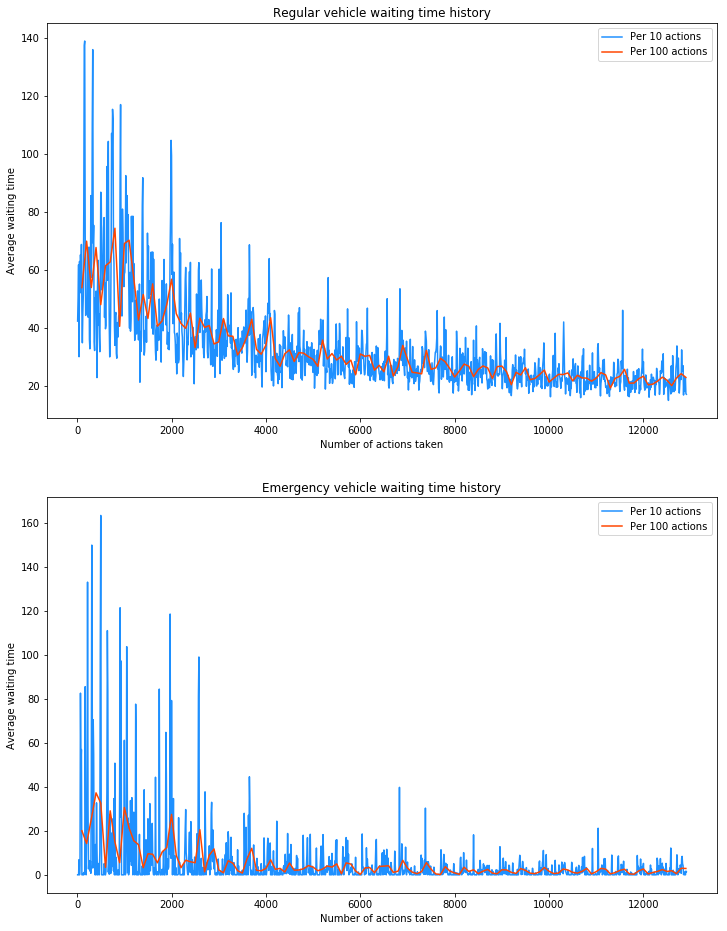

In [14]:
# vehicle average waiting time history  
fig=plt.figure()
ax = fig.add_subplot(211)
fig.set_size_inches(12,16)
plot(xaxis_per_10,regular_waiting_per_10,'Number of actions taken','Average waiting time','Regular vehicle waiting time history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,regular_waiting_per_100,'Number of actions taken','Average waiting time','Regular vehicle waiting time history',color='orangered',label='Per 100 actions')
ax = fig.add_subplot(212)
plot(xaxis_per_10,emg_waiting_per_10,'Number of actions taken','Average waiting time','Emergency vehicle waiting time history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,emg_waiting_per_100,'Number of actions taken','Average waiting time','Emergency vehicle waiting time history',color='orangered',label='Per 100 actions')

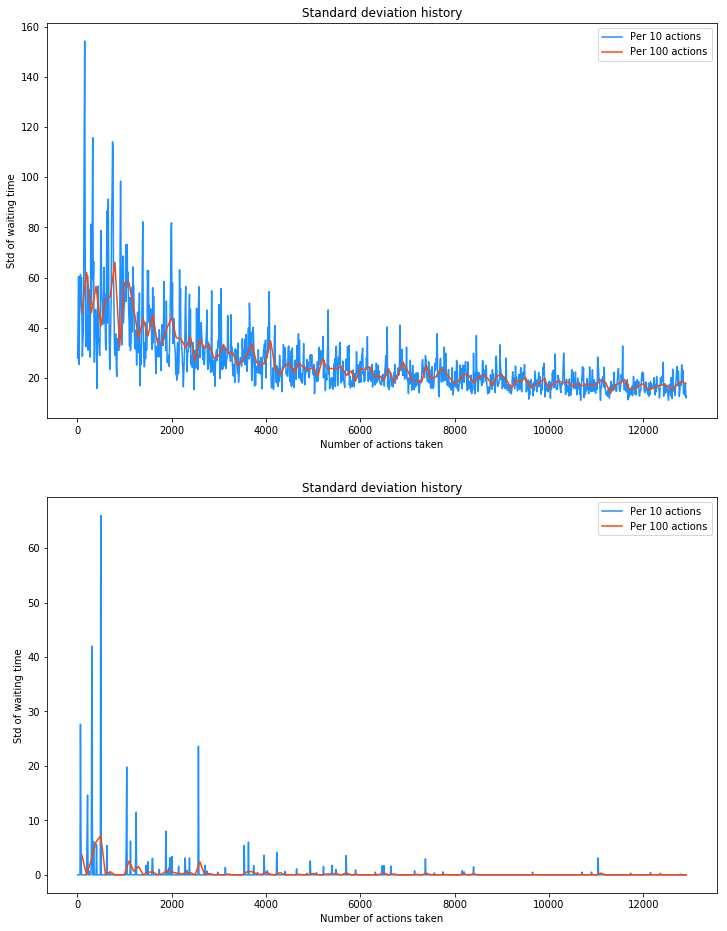

In [15]:
# vehicle waiting time std history
fig=plt.figure()
ax = fig.add_subplot(211)
fig.set_size_inches(12,16)
plot(xaxis_per_10,reg_std_per_10,'Number of actions taken','Std of waiting time','Standard deviation history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,reg_std_per_100,'Number of actions taken','Std of waiting time','Standard deviation history',color='orangered',label='Per 100 actions')
ax = fig.add_subplot(212)
plot(xaxis_per_10,emg_std_per_10,'Number of actions taken','Std of waiting time','Standard deviation history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,emg_std_per_100,'Number of actions taken','Std of waiting time','Standard deviation history',color='orangered',label='Per 100 actions')

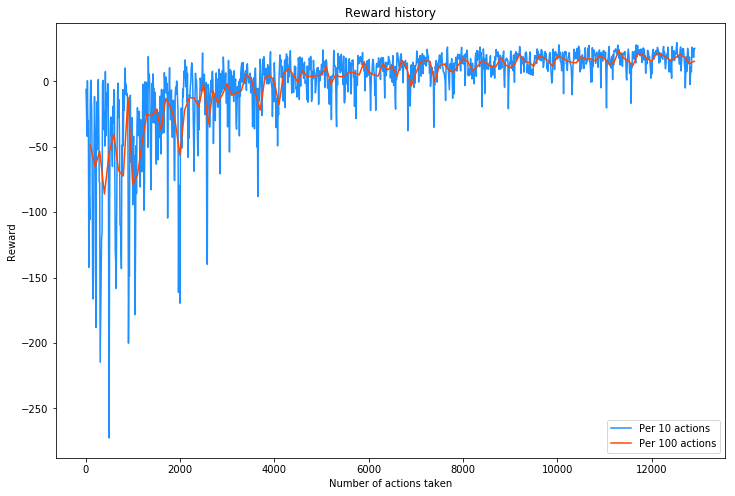

In [16]:
#reward history
fig=plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(12,8)
plot(xaxis_per_10,reward_per_10,'Number of actions taken','Reward','Reward history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,reward_per_100,'Number of actions taken','Reward','Reward history',color='orangered',label='Per 100 actions')

# Save statistics

In [17]:
regular_waiting_per_100,reg_std_per_100,emg_waiting_per_100,emg_std_per_100,reward_per_100,xaxis_per_100 = avgStatis(100)
regular_waiting_per_10,reg_std_per_10,emg_waiting_per_10,emg_std_per_10,reward_per_10,xaxis_per_10 = avgStatis(10)
file_list=['regular_waiting_per_100','reg_std_per_100','emg_waiting_per_100','emg_std_per_100','reward_per_100','xaxis_per_100','regular_waiting_per_10','reg_std_per_10','emg_waiting_per_10','emg_std_per_10','reward_per_10','xaxis_per_10']
today = datetime.now()
def saveStatistics():
    # define the name of the directory to be created
    path = "statistics/{}.{}.{}-{}.{}{}/".format(today.strftime('%Y'),today.strftime('%m'),today.strftime('%d'),today.strftime('%I'),today.strftime('%M'),today.strftime('%p'))
    os.mkdir(path)
    for file_name in file_list:
        # open output file for writing
        with open(path+'{}.txt'.format(file_name), 'w') as filehandle:
            json.dump(eval(file_name), filehandle)
saveStatistics()

# Testing

In [10]:
sumo_env=Sumo(K=0.5,Z=1)

Agent = load_model('models/proposed/DQN.h5')
traci.start([sumo_env.getSumoBinary(gui=True), "-c", "cross3ltl.sumocfg", '--start'])
count=0
step_count = 1  
action_count=[]
regular_waiting_history=[]
emergency_waiting_history=[]
regular_std_history=[]
emergency_std_history=[]
reward_history=[]

 Retrying in 1 seconds


In [11]:
while traci.simulation.getMinExpectedNumber()>0:
  
        traci.simulationStep()
        sumo_env.updateWaitingTime()
        if(count % 12 == 0):#agent will make a decision at the 12th second of the current phase
            
            current_state,current_state_distribution=sumo_env.getState()
            action=np.argmax(Agent.predict(current_state)[0])
            sumo_env.changePhase(action)
            reward,regular_waiting,regular_std,emergency_waiting,emergency_std = sumo_env.reward(current_state_distribution)
            print("waiting ",regular_waiting," regular_std ",regular_std," reward ",reward)
                 
            action_count.append(step_count)

            regular_waiting_history.append(regular_waiting)
            emergency_waiting_history.append(emergency_waiting)

            regular_std_history.append(regular_std)
            emergency_std_history.append(emergency_std)     
            reward_history.append(reward)
        count+=1
            
traci.close()

waiting  0.0  regular_std  0.0  reward  50.0
waiting  0.0  regular_std  0.0  reward  50.0
waiting  0.0  regular_std  0.0  reward  50.0
waiting  3.0  regular_std  0.82  reward  46.59175170953614
waiting  6.43  regular_std  4.95  reward  41.095009168091465
waiting  11.3  regular_std  7.6  reward  29.898355618945928
waiting  16.19  regular_std  11.18  reward  28.224514143047603
waiting  24.81  regular_std  14.11  reward  18.133647440050932
waiting  20.1  regular_std  15.13  reward  22.337097118169503
waiting  22.71  regular_std  14.17  reward  20.206919773256924
waiting  22.86  regular_std  14.78  reward  19.751121548151335
waiting  17.71  regular_std  17.16  reward  23.705361788317
waiting  24.67  regular_std  21.16  reward  14.752428100057898
waiting  22.21  regular_std  15.36  reward  20.104153405852664
waiting  18.2  regular_std  16.49  reward  23.55742758600205
waiting  15.83  regular_std  11.61  reward  28.363769880482103
waiting  23.37  regular_std  13.9  reward  19.682117540150195

FatalTraCIError: connection closed by SUMO

In [26]:
regular_waiting_per_100,reg_std_per_100,emg_waiting_per_100,emg_std_per_100,reward_per_100,xaxis_per_100 = avgStatis(100)
regular_waiting_per_10,reg_std_per_10,emg_waiting_per_10,emg_std_per_10,reward_per_10,xaxis_per_10 = avgStatis(10)

In [27]:

file_list=['regular_waiting_per_100','reg_std_per_100','emg_waiting_per_100','emg_std_per_100','reward_per_100','xaxis_per_100','regular_waiting_per_10','reg_std_per_10','emg_waiting_per_10','emg_std_per_10','reward_per_10','xaxis_per_10']
today = datetime.now()
def saveStatistics():
    # define the name of the directory to be created
    path = "statistics/Testing/{}.{}.{}-{}.{}{}/".format(today.strftime('%Y'),today.strftime('%m'),today.strftime('%d'),today.strftime('%I'),today.strftime('%M'),today.strftime('%p'))
    os.mkdir(path)
    for file_name in file_list:
        # open output file for writing
        with open(path+'{}.txt'.format(file_name), 'w') as filehandle:
            json.dump(eval(file_name), filehandle)
saveStatistics()

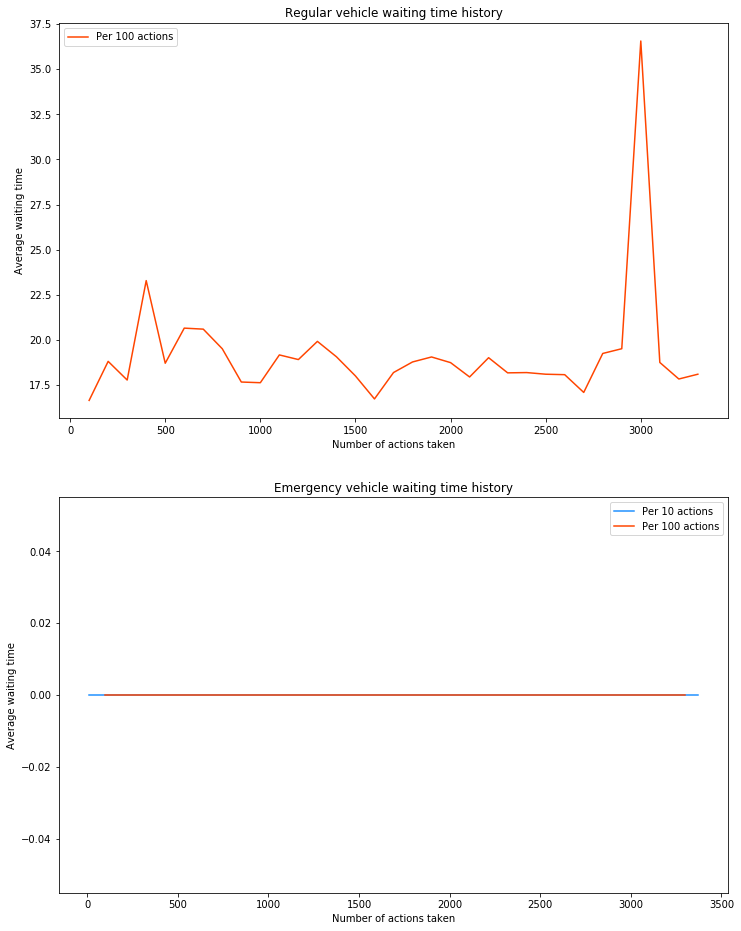

In [29]:
# vehicle average waiting time history  
fig=plt.figure()
ax = fig.add_subplot(211)
fig.set_size_inches(12,16)
# plot(xaxis_per_10,regular_waiting_per_10,'Number of actions taken','Average waiting time','Regular vehicle waiting time history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,regular_waiting_per_100,'Number of actions taken','Average waiting time','Regular vehicle waiting time history',color='orangered',label='Per 100 actions')
ax = fig.add_subplot(212)
plot(xaxis_per_10,emg_waiting_per_10,'Number of actions taken','Average waiting time','Emergency vehicle waiting time history',color='dodgerblue',label='Per 10 actions')
plot(xaxis_per_100,emg_waiting_per_100,'Number of actions taken','Average waiting time','Emergency vehicle waiting time history',color='orangered',label='Per 100 actions')